In [1]:
import pandas as pd
import numpy as np
import cv2
import IPython.display as ipd
import librosa
import ndjson
import os

# Video dataframe

In [2]:
ipd.Video("D:\\MANAGER-ANGRY-METER\\data\\videos\\cmhphcl8x0m3l0766dfoqpmje.mp4", width=700, embed=True)


In [3]:

# Open and read the NDJSON file
with open('D:\\MANAGER-ANGRY-METER\\video-input\\videos.ndjson', 'r') as f:
    data = ndjson.load(f)


print(f"Combined records: {len(data)}")


Combined records: 69


In [4]:
df_meta = pd.DataFrame(data)
df_meta.drop(columns=['media_attributes'], inplace=True)
df_meta['data_row'] = df_meta['data_row'].astype(str).str[8:37]
df_meta.rename(columns={'data_row': 'id'}, inplace=True)
df_meta.rename(columns={'metadata_fields': 'emotion'}, inplace=True)
df_meta.head()

id                   emotion
0  cmhpke9p4cjbs0782sob057xx.mp4  [{'value': 'Surprised'}]
1  cmhpke9p4cjbt0782363n2x0u.mp4  [{'value': 'Surprised'}]
2  cmhpke9p4cjbu0782assgc5x9.mp4  [{'value': 'Surprised'}]
3  cmhpke9p4cjbv0782ah5bfrg4.mp4  [{'value': 'Surprised'}]
4  cmhpke9p4cjbw0782wkp7yx3s.mp4  [{'value': 'Surprised'}]

In [5]:
import mediapipe as mp

casc_path = (r"C:\\Users\\PC\\anaconda3\\pkgs\\opencv-4.12.0-py312h6fcf9f4_0\\Library\\etc\\haarcascades\\haarcascade_frontalface_default.xml")

class EmotionFeatureExtractor:
    def __init__(self):
        self.mp_face_mesh = mp.solutions.face_mesh
        
        # --- CONFIGURATION FOR LINEAR TRACKING ---
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=False,        # FALSE = Enable Linear Tracking (Faster & Smoother)
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5     # Tracking needs this to be balanced
        )

    def reset(self):
        self.face_mesh.reset()

    def get_features(self, frame):
        # 1. Convert to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # 2. Process (Updates the internal tracker)
        results = self.face_mesh.process(rgb_frame)
        
        if not results.multi_face_landmarks:
            return None
        
        landmarks = results.multi_face_landmarks[0]
        
        # 3. Extract & Normalize (Same as before)
        coords = []
        for lm in landmarks.landmark:
            coords.append(lm.x)
            coords.append(lm.y)
        
        coords = np.array(coords).reshape(-1, 2)
        
        # Center & Scale
        nose_x, nose_y = coords[1] 
        coords[:, 0] -= nose_x
        coords[:, 1] -= nose_y
        
        dist = np.linalg.norm(coords[234] - coords[454]) + 1e-6
        coords /= dist
        
        return coords.flatten()

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [6]:
def process_video_dataset():
    
    data_rows = []
    # Initialize Extractor (Make sure static_image_mode=False in the class!)
    extractor = EmotionFeatureExtractor()
    
    ROOT_DIR = r"D:\Manager-ANGRY-METER\data\videos"

    # --- USER'S EXACT LOOP LOGIC ---
    for filename in os.listdir(ROOT_DIR):
        if filename.endswith(('.mp4')):
            
            # CRUCIAL: os.path.join handles backslashes correctly for the OS!
            video_path = os.path.join(ROOT_DIR, filename)
            
            # Get the ID (filename including extension)
            video_id = os.path.basename(video_path) 
            
            print(f"Processing: {video_id}")
            
            # --- NEW: RESET TRACKER FOR LINEARITY ---
            # Tells MediaPipe: "New video, forget previous face history"
            extractor.reset()
            
            cap = cv2.VideoCapture(video_path)
            
            while True:
                ret, frame = cap.read()
                if not ret: break
                
                # --- PROCESS EVERY FRAME (No Skipping) ---
                features = extractor.get_features(frame)
                
                if features is not None:
                    # Save ID + Features (No Emotion Column)
                    row = [video_id] + features.tolist()
                    data_rows.append(row)
            
            cap.release()

    return data_rows

# # --- RUN AND BUILD DATAFRAME ---
# DATA_ROWS = process_video_dataset()

# if len(DATA_ROWS) > 0:
#     # Build DataFrame
#     # Columns: ID, Pixel_0, Pixel_1...
#     num_features = len(DATA_ROWS[0]) - 1  # Minus 1 for 'id'
#     feature_cols = [f'pixel_{i}' for i in range(num_features)]
    
#     column_names = ['id'] + feature_cols 
    
#     df_final = pd.DataFrame(DATA_ROWS, columns=column_names)

#     print(f"✅ Dataframe Shape: {df_final.shape}")
#     print(df_final.head())
# else:
#     print("❌ No data processed.")

In [7]:

# Define a filename for your "saved brain"
CACHE_FILE = "video_features_data.pkl"

# 1. CHECK IF SAVE FILE EXISTS
if os.path.exists(CACHE_FILE):
    print(f"🚀 Found '{CACHE_FILE}'! Loading data directly from disk...")
    print("   (This should take only a few seconds)")
    
    # Load the dataframe instantly
    df_final = pd.read_pickle(CACHE_FILE)

else:
    print(f"🐢 No cache found. Starting heavy video processing...")
    
    # 2. RUN THE HEAVY PROCESSING (Only happens once!)
    # Call your function
    DATA_ROWS = process_video_dataset() 
    
    # Create DataFrame
    num_features = len(DATA_ROWS[0]) - 1
    column_names = ['id'] + [f'pixel_{i}' for i in range(num_features)]
    df_features = pd.DataFrame(DATA_ROWS, columns=column_names)
    
    # Merge with metadata (assuming df_meta is loaded)
    df_final = pd.merge(df_features, df_meta, on='id', how='left')
    
    # 3. SAVE TO PICKLE
    print("💾 Saving processed data to disk for next time...")
    df_final.to_pickle(CACHE_FILE)

print(f"✅ Data Ready. Shape: {df_final.shape}")

🚀 Found 'video_features_data.pkl'! Loading data directly from disk...
   (This should take only a few seconds)
✅ Data Ready. Shape: (4677, 958)


In [8]:
# df_final = pd.merge(
#     df_features, 
#     df_meta,
#     on='id', 
#     how='left'
# )

# print(f"Original Feature Shape: {df_features.shape}")
# print(f"Final Merged Shape:     {df_final.shape}")
# print("\nFirst 5 rows of the merged data, showing the copied emotion:")
# print(df_final[['id', 'emotion', 'pixel_0']].head())
# df_final['emotion'].value_counts()

# audio dataframe

In [9]:
ipd.Audio('D:\\MANAGER-ANGRY-METER\\data\\audio\cmi6kcmpg14ez0766uu4u0g71.WAV')

In [10]:
y, sr = librosa.load('D:\\MANAGER-ANGRY-METER\\data\\audio\cmi6kcmpg14ez0766uu4u0g71.WAV')
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [0.00102723 0.00164699 0.00166353 0.00174626 0.00082285 0.00056149
 0.00096017 0.00134913 0.00153695 0.00194241]
shape y: (100352,)
sr: 22050


In [11]:
y_trimmed, index = librosa.effects.trim(y, top_db=20)
ipd.Audio(y_trimmed, rate=sr)

In [12]:


# Open and read the NDJSON file
with open('D:\\MANAGER-ANGRY-METER\\video-input\\Audio.ndjson', 'r') as f:
    data = ndjson.load(f)


print(f"Combined records: {len(data)}")



Combined records: 50


In [13]:
df_audio_meta = pd.DataFrame(data)
df_audio_meta.drop(columns=['media_attributes'], inplace=True)
df_audio_meta['data_row'] = df_audio_meta['data_row'].astype(str).str[8:37]
df_audio_meta.rename(columns={'data_row': 'id'}, inplace=True)
df_audio_meta.rename(columns={'metadata_fields': 'emotion'}, inplace=True)
df_audio_meta.head()

id               emotion
0  cmi6kb42m14t80768b3k66mu7.WAV  [{'value': 'Angry'}]
1  cmi6kb42m14t907681xw39xws.WAV  [{'value': 'Angry'}]
2  cmi6kb42m14ta0768107er0vz.WAV  [{'value': 'Angry'}]
3  cmi6kb42m14tb0768roy88bhh.WAV  [{'value': 'Angry'}]
4  cmi6kb42m14tc076895ghj9du.WAV  [{'value': 'Angry'}]

In [14]:
class AudioFeatureExtractor:
    def __init__(self):
        self.sample_rate = 22050
        
        # --- IMPROVEMENT 1: Larger Window, Small Step ---
        self.duration = 2.0  # Look at 2 seconds at a time (Capture full words)
        self.step = 0.5      # Slide forward by 0.5 seconds
        self.n_mfcc = 40

    def get_features(self, audio_path):
        try:
            # 1. Load Audio
            y, sr = librosa.load(audio_path, sr=self.sample_rate)
            
            # 2. Trim Silence
            y_trimmed, _ = librosa.effects.trim(y, top_db=20)
            
            # Calculate samples
            window_samples = int(self.duration * sr)
            step_samples = int(self.step * sr)
            total_samples = len(y_trimmed)
            
            vectors = []
            
            # --- IMPROVEMENT 2: Sliding Window Loop ---
            # If audio is shorter than 2s, we pad it.
            # If longer, we slide.
            
            if total_samples < window_samples:
                # Pad short clips
                y_chunk = np.pad(y_trimmed, (0, window_samples - total_samples))
                vectors.append(self._extract_stats(y_chunk, sr))
            else:
                # Slide through the audio
                for start in range(0, total_samples - window_samples, step_samples):
                    end = start + window_samples
                    chunk = y_trimmed[start:end]
                    
                    # Extract rich features for this window
                    vectors.append(self._extract_stats(chunk, sr))
                    
            return vectors

        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return []

    def _extract_stats(self, y, sr):
        # --- IMPROVEMENT 3: RICH FEATURE SET ---
        # Anger is often Loud (RMS), High Pitch (Chroma), and Rough (Contrast)
        
        # 1. MFCC (Voice Texture)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
        
        # 2. Chroma (Pitch/Tonal content) - Good for intonation
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # 3. Spectral Contrast (Roughness/Brightness)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        
        # 4. Zero Crossing Rate (Noisiness/Shouting)
        zcr = librosa.feature.zero_crossing_rate(y)
        
        # --- AGGREGATE STATS (Mean & Std Dev) ---
        # We assume the emotion is constant inside this 2-second window.
        features = []
        
        # Add Mean and Std for all feature types
        for feat in [mfcc, chroma, contrast, zcr]:
            features.append(np.mean(feat, axis=1))
            features.append(np.std(feat, axis=1))
            
        # Flatten into one long vector (approx 100-150 numbers)
        return np.concatenate(features)

In [15]:
def process_audio_dataset():
    data_rows = []
    extractor = AudioFeatureExtractor()
    
    ROOT_DIR = r"D:\MANAGER-ANGRY-METER\data\audio"

    print("✂️  Slicing audio files into segments...")

    # Loop through all files directly inside the ROOT_DIR
    for filename in os.listdir(ROOT_DIR):
        if filename.lower().endswith(('.wav', '.mp4', '.mp3')):
            
            video_path = os.path.join(ROOT_DIR, filename)
            # We keep the original ID (e.g. "video1.wav") so we can merge with emotions later
            original_id = os.path.basename(video_path) 
            
            # --- EXTRACT AUDIO FEATURES ---
            # Now returns a LIST of vectors (one for each 0.5s chunk)
            chunk_list = extractor.get_features(video_path)
            
            # Check if list is not empty
            if chunk_list:
                # NEW LOOP: Iterate through every 0.5s chunk
                for i, vector in enumerate(chunk_list):
                    
                    # vector is a NumPy array, so .tolist() works here!
                    # We add the original_id so this chunk gets the right label later
                    row = [original_id] + vector.tolist()
                    data_rows.append(row)

    print(f"✅ Processing Complete. Generated {len(data_rows)} total segments.")
    return data_rows


In [16]:

# --- RUN AND BUILD DATAFRAME ---
AUDIO_DATA_ROWS = process_audio_dataset()

if len(AUDIO_DATA_ROWS) > 0:
    # Calculate feature columns (Total length - 1 for 'id')
    num_features = len(AUDIO_DATA_ROWS[0]) - 1 
    
    column_names = ['id'] + [f'mfcc_{i}' for i in range(num_features)]
    
    df_audio_features = pd.DataFrame(AUDIO_DATA_ROWS, columns=column_names)
    
    print(f"\nExample of Segmented Data:")
    print(df_audio_features.head())
    print(f"Total Rows (Segments): {len(df_audio_features)}")
    

✂️  Slicing audio files into segments...
✅ Processing Complete. Generated 95 total segments.

Example of Segmented Data:
                              id      mfcc_0      mfcc_1     mfcc_2  \
0  cmi6k8w160dcg075166shconq.WAV -513.561768   49.494762 -16.199219   
1  cmi6k8w160dch07518w0z2ghr.WAV -573.954712   56.785313  -2.850954   
2  cmi6k8w160dci0751dqq8vv7f.WAV -367.438049  141.136444 -12.092526   
3  cmi6k8w160dcj075151x2h6h2.WAV -460.852875   82.447716  -8.276977   
4  cmi6k8w160dck0751xfihqptv.WAV -399.324219   56.620792  -8.664677   

      mfcc_3     mfcc_4     mfcc_5    mfcc_6     mfcc_7    mfcc_8  ...  \
0   2.798029   1.335076   1.880273  2.706469  -0.336792 -1.920434  ...   
1  15.505120   2.225241   4.380421 -1.999681   1.939196 -0.512721  ...   
2  33.898346  -6.131912  18.025145  5.908717   6.545364 -6.104983  ...   
3  26.723400  -1.088647   0.521629  5.090024  -0.918464  2.270508  ...   
4  12.136850 -11.232705  -0.186267  9.762609 -12.915164  3.969986  ...   

    mfc

In [17]:
df_Audio = pd.merge(
    df_audio_features, 
    df_audio_meta,  # Only select the columns you need from df_audio_meta
    on='id', 
    how='left'
)

print(f"Original Feature Shape: {df_audio_features.shape}")
print(f"Final Merged Shape:     {df_Audio.shape}")
print("\nFirst 5 rows of the merged data, showing the copied emotion:")
print(df_Audio[['id', 'mfcc_1', 'emotion']])

Original Feature Shape: (95, 121)
Final Merged Shape:     (95, 122)

First 5 rows of the merged data, showing the copied emotion:
                               id      mfcc_1                   emotion
0   cmi6k8w160dcg075166shconq.WAV   49.494762  [{'value': 'Surprised'}]
1   cmi6k8w160dch07518w0z2ghr.WAV   56.785313  [{'value': 'Surprised'}]
2   cmi6k8w160dci0751dqq8vv7f.WAV  141.136444  [{'value': 'Surprised'}]
3   cmi6k8w160dcj075151x2h6h2.WAV   82.447716  [{'value': 'Surprised'}]
4   cmi6k8w160dck0751xfihqptv.WAV   56.620792  [{'value': 'Surprised'}]
..                            ...         ...                       ...
90  cmi6kdbtk2t3m0743o81zpaar.WAV   35.068745      [{'value': 'Happy'}]
91  cmi6kdbtk2t3n0743o9m97lw9.WAV  144.223206      [{'value': 'Happy'}]
92  cmi6kdbtk2t3n0743o9m97lw9.WAV  143.130844      [{'value': 'Happy'}]
93  cmi6kdbtk2t3n0743o9m97lw9.WAV  140.548126      [{'value': 'Happy'}]
94  cmi6kdbtk2t3o0743g5jmbaye.WAV   93.527130      [{'value': 'Happy'}]

[95 r

In [18]:
# --- ROBUST DATA CLEANING ---
def clean_emotion_col(x):
    # 1. If it's a list (e.g., ['angry']), grab the first item
    if isinstance(x, list):
        if len(x) > 0:
            x = x[0]
        else:
            return "unknown"

    # 2. If it's a dictionary (e.g., {'label': 'angry'}), grab the value
    if isinstance(x, dict):
        # Try common keys, or just grab the first value found
        x = x.get('label', x.get('emotion', list(x.values())[0]))

    # 3. Convert whatever is left to a string and lower-case it
    text = str(x).lower()
    
    # 4. Remove any leftover garbage characters
    text = text.replace("'", "").replace('"', "").strip()
    return text

# Apply the fix
print("Cleaning data...")
df_final['emotion'] = df_final['emotion'].apply(clean_emotion_col)
df_Audio['emotion'] = df_Audio['emotion'].apply(clean_emotion_col)
# --- VERIFY ---
print("\nUnique emotions found:")
print(df_final['emotion'].unique())
print(df_Audio['emotion'].unique())

Cleaning data...

Unique emotions found:
['happy' 'sad' 'neutral' 'angry' 'disgust' 'surprised']
['surprised' 'disgust' 'angry' 'neutral' 'sad' 'happy']


# Video Data Cleaning

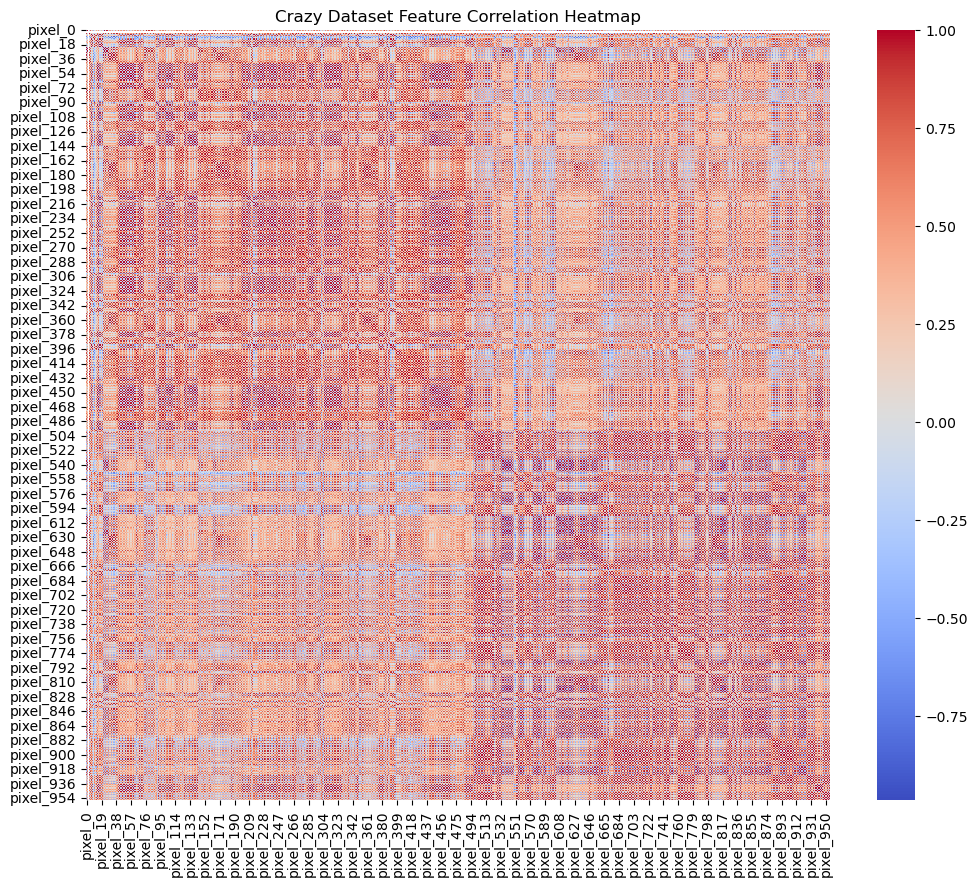

In [19]:
df_heatmap = df_final.drop(columns=['id', 'emotion'])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
correlation_matrix = df_heatmap.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Crazy Dataset Feature Correlation Heatmap')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1. Create a copy so we don't mess up the original data
target_dummies = pd.get_dummies(df_final['emotion'], prefix='target')

df_final = df_final.drop(columns=['id', 'emotion'])

df_corr = pd.concat([df_final, target_dummies], axis=1)

corr_matrix = df_corr.corr()

feature_cols = df_final.columns
target_cols = target_dummies.columns

target_correlations = corr_matrix.loc[feature_cols, target_cols].abs()
max_score = target_correlations.max(axis=1)

features_to_drop = max_score[max_score < 0.2 ].index.tolist()
print(f"Dropping {len(features_to_drop)} features with low correlation to targets.")

df_final = df_final.drop(columns=features_to_drop)

Dropping 394 features with low correlation to targets.


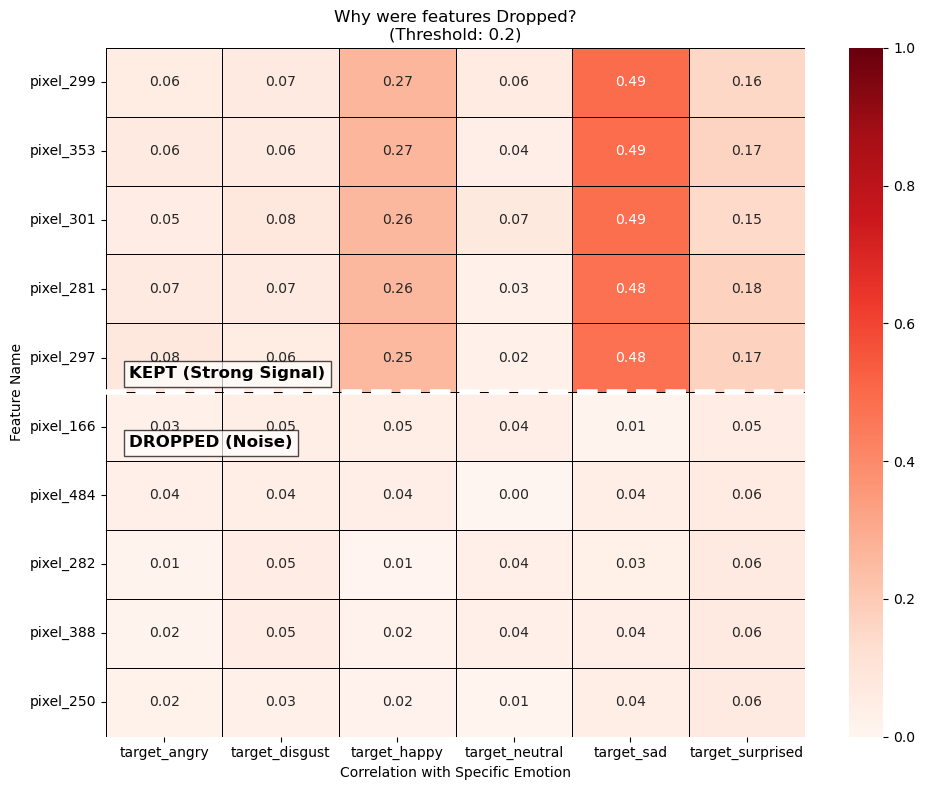

In [21]:
kept_features = max_score[max_score >= 0.2].sort_values(ascending=False).head(5).index.tolist()
dropped_features = max_score[max_score < 0.2].sort_values(ascending=True).head(5).index.tolist()
features_to_plot = kept_features + dropped_features

plot_data = target_correlations.loc[features_to_plot]

plt.figure(figsize=(10, 8))
sns.heatmap(
        plot_data, 
        annot=True,       # Show the numbers
        fmt=".2f",        # 2 decimal places
        cmap='Reds',  # Red = High, Blue = Low
        vmin=0, vmax=1,   # Scale from 0 to 1
        linewidths=0.5,
        linecolor='black'
    )

plt.axhline(len(kept_features), color='white', linewidth=4, linestyle='--')
plt.text(0.2, len(kept_features) - 0.2, "KEPT (Strong Signal)", color='black', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
plt.text(0.2, len(kept_features) + 0.8, "DROPPED (Noise)", color='black', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))

plt.title(f"Why were features Dropped?\n(Threshold: {0.2})")
plt.xlabel("Correlation with Specific Emotion")
plt.ylabel("Feature Name")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
corr_matrix = df_final.corr().abs()

mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper = corr_matrix.where(mask)

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"✅ Dropped {len(to_drop)} redundant features.")
df_final = df_final.drop(columns=to_drop)

✅ Dropped 525 redundant features.


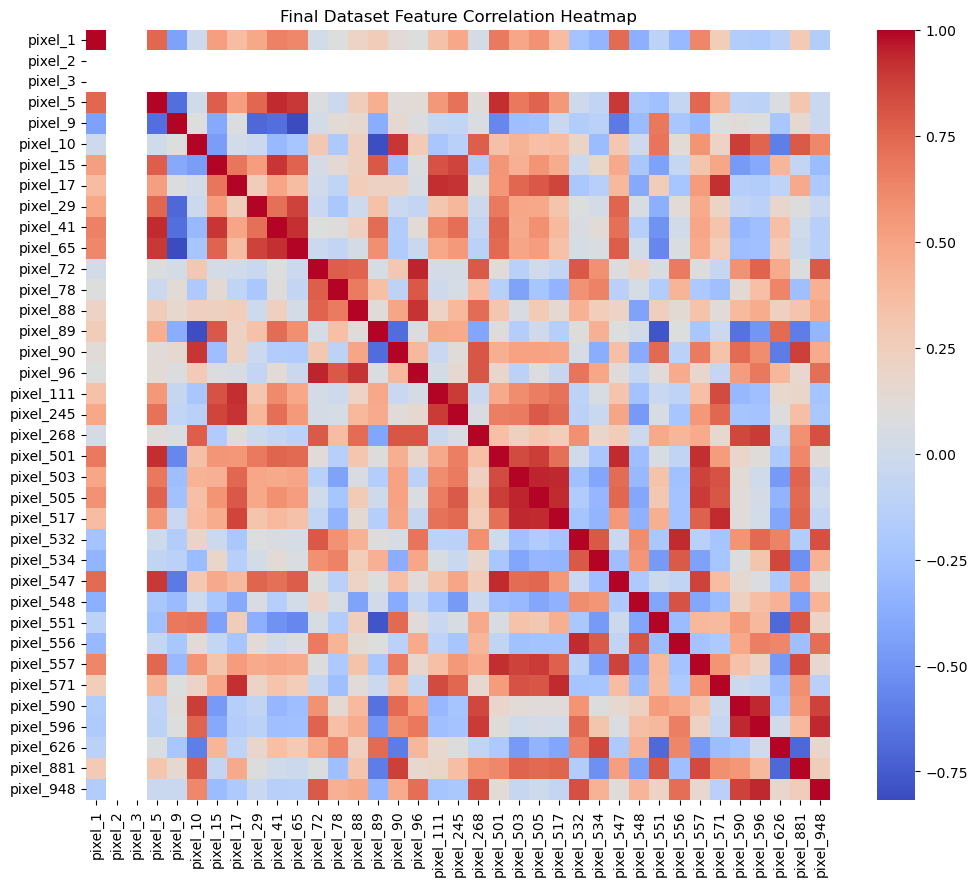

In [23]:
#df_final heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
correlation_matrix = df_final.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Final Dataset Feature Correlation Heatmap')
plt.show()

In [24]:
df_final = df_final.drop(columns=['pixel_1', 'pixel_2'])

df_final['emotion'] = target_dummies.idxmax(axis=1).str.replace('target_', '')
print(df_final.head())

   pixel_3   pixel_5   pixel_9  pixel_10  pixel_15  pixel_17  pixel_29  \
0      0.0  0.096702 -0.096516 -0.012913 -0.569397 -0.713452  0.389646   
1      0.0  0.093563 -0.092371 -0.005501 -0.535694 -0.682972  0.499860   
2      0.0  0.089669 -0.095217 -0.006317 -0.512413 -0.697063  0.490930   
3      0.0  0.079694 -0.094109 -0.005154 -0.536348 -0.690860  0.435799   
4      0.0  0.086485 -0.091090 -0.004858 -0.481946 -0.657281  0.422976   

   pixel_41  pixel_65  pixel_72  ...  pixel_551  pixel_556  pixel_557  \
0  0.053654  0.818569 -0.379258  ...  -0.087102   0.058190  -0.005811   
1  0.045587  0.790666 -0.341590  ...  -0.081124   0.074653   0.003996   
2  0.046872  0.787021 -0.334314  ...  -0.087283   0.092672  -0.012767   
3  0.041754  0.755235 -0.314312  ...  -0.090348   0.110599  -0.035216   
4  0.047182  0.757142 -0.290945  ...  -0.087633   0.118942  -0.025690   

   pixel_571  pixel_590  pixel_596  pixel_626  pixel_881  pixel_948  emotion  
0  -0.706345   0.062956   0.136547  -

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- PREPARATION ---
# 1. Create a helper dataframe to calculate correlations
df_calc = df_final.copy()
df_calc['emotion_code'] = df_calc['emotion'].astype('category').cat.codes

# 2. Calculate correlations (ignoring the text column to avoid errors)
correlations = df_calc.corr(numeric_only=True)['emotion_code'].abs().drop('emotion_code')

# 3. Get the Top 2 Winners
best_feature = correlations.idxmax()
second_best_feature = correlations.sort_values(ascending=False).index[1]

print(f"🥇 Best Feature: '{best_feature}'")
print(f"🥈 2nd Best:    '{second_best_feature}'")

🥇 Best Feature: 'pixel_9'
🥈 2nd Best:    'pixel_111'


👑 The King Feature is: 'pixel_9'
   Correlation Strength: 0.206


C:\Users\PC\AppData\Local\Temp\ipykernel_14732\3869211469.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='emotion', y=best_feature, data=df_final, palette='coolwarm')


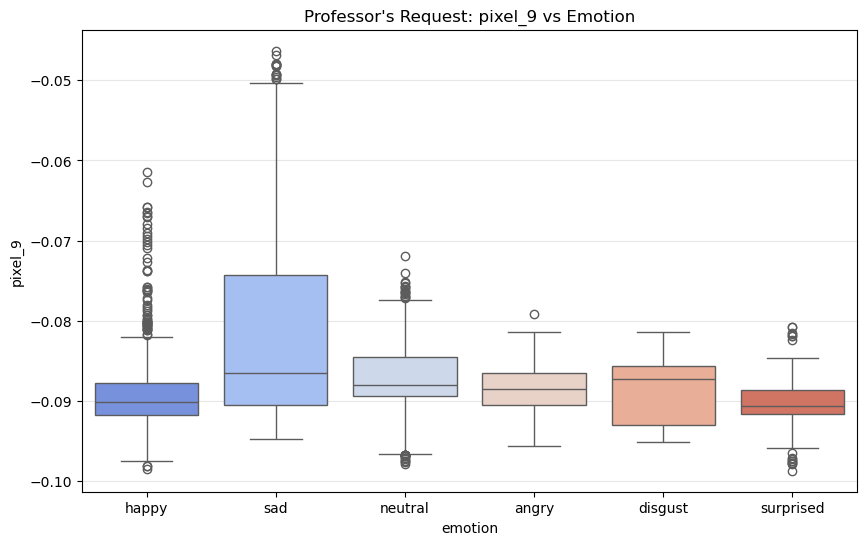

In [26]:
# 1. Setup the calculation dataframe
df_calc = df_final.copy()
df_calc['emotion_code'] = df_calc['emotion'].astype('category').cat.codes

# 2. Calculate Correlation (FIXED: added numeric_only=True)
# This prevents it from trying to calculate "happy" * "sad"
correlations = df_calc.corr(numeric_only=True)['emotion_code'].abs().drop('emotion_code')

# 3. Find the Winner
best_feature = correlations.idxmax()
best_score = correlations.max()

print(f"👑 The King Feature is: '{best_feature}'")
print(f"   Correlation Strength: {best_score:.3f}")

# 4. PLOT IT (Box Plot is best for Feature vs Category)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y=best_feature, data=df_final, palette='coolwarm')
plt.title(f'Professor\'s Request: {best_feature} vs Emotion')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_14732\2553696523.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


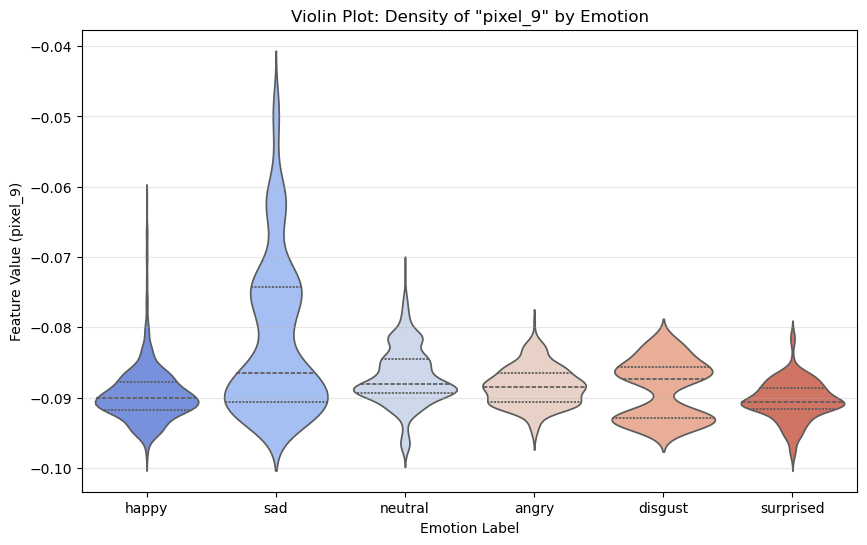

In [27]:
# --- VIOLIN PLOT ---
plt.figure(figsize=(10, 6))

sns.violinplot(
    x='emotion', 
    y=best_feature, 
    data=df_final, 
    palette='coolwarm', 
    inner='quartile'  # Draws lines for the median and quartiles inside
)

plt.title(f'Violin Plot: Density of "{best_feature}" by Emotion')
plt.xlabel('Emotion Label')
plt.ylabel(f'Feature Value ({best_feature})')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

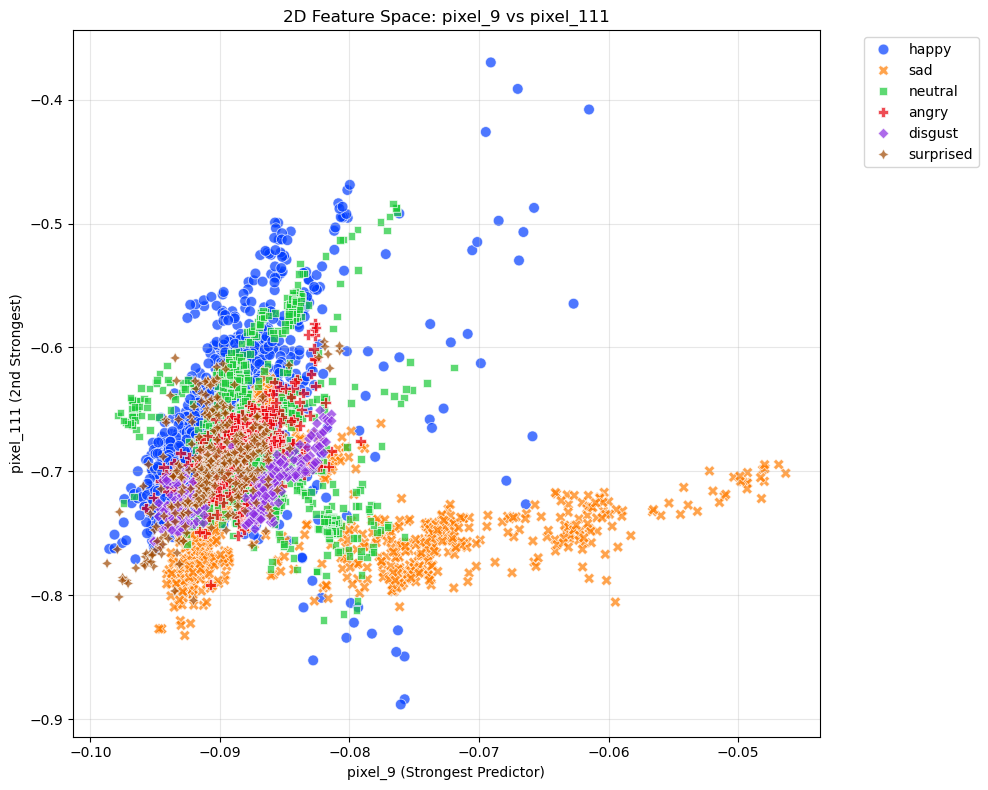

In [28]:
# --- 2D SCATTER PLOT ---
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df_final, 
    x=best_feature, 
    y=second_best_feature, 
    hue='emotion',      # Color dots by Emotion
    style='emotion',    # different shapes for different emotions (optional, helps accessibility)
    palette='bright',
    alpha=0.7,          # Make dots slightly transparent to see overlaps
    s=60                # Dot size
)

plt.title(f'2D Feature Space: {best_feature} vs {second_best_feature}')
plt.xlabel(f"{best_feature} (Strongest Predictor)")
plt.ylabel(f"{second_best_feature} (2nd Strongest)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside if it blocks data
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_14732\343576022.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


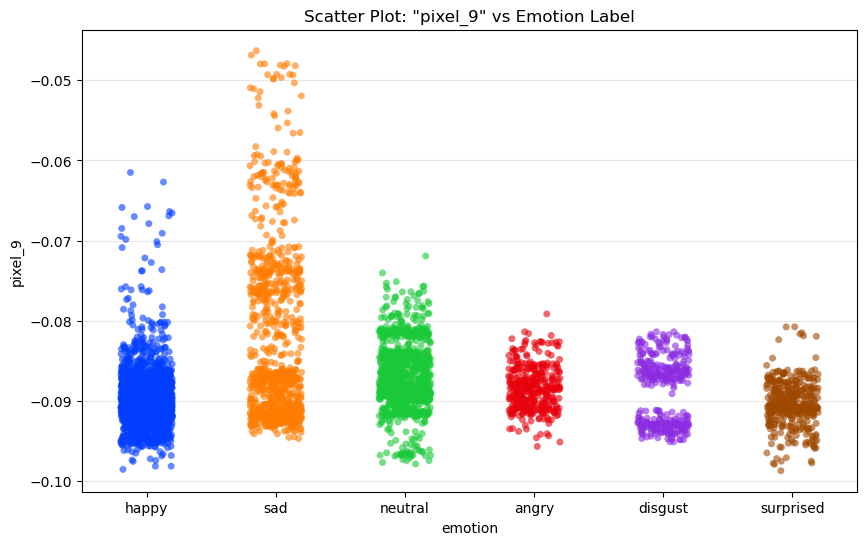

In [29]:
plt.figure(figsize=(10, 6))

# The 'jitter=True' is the magic that turns vertical lines into a scatter cloud
sns.stripplot(
    data=df_final, 
    x='emotion', 
    y=best_feature, 
    palette='bright', 
    jitter=0.2,    # Spread the dots out horizontally
    alpha=0.6,     # Make them see-through so you can see density
    size=5         # Dot size
)

plt.title(f'Scatter Plot: "{best_feature}" vs Emotion Label')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Audio Data Cleaning

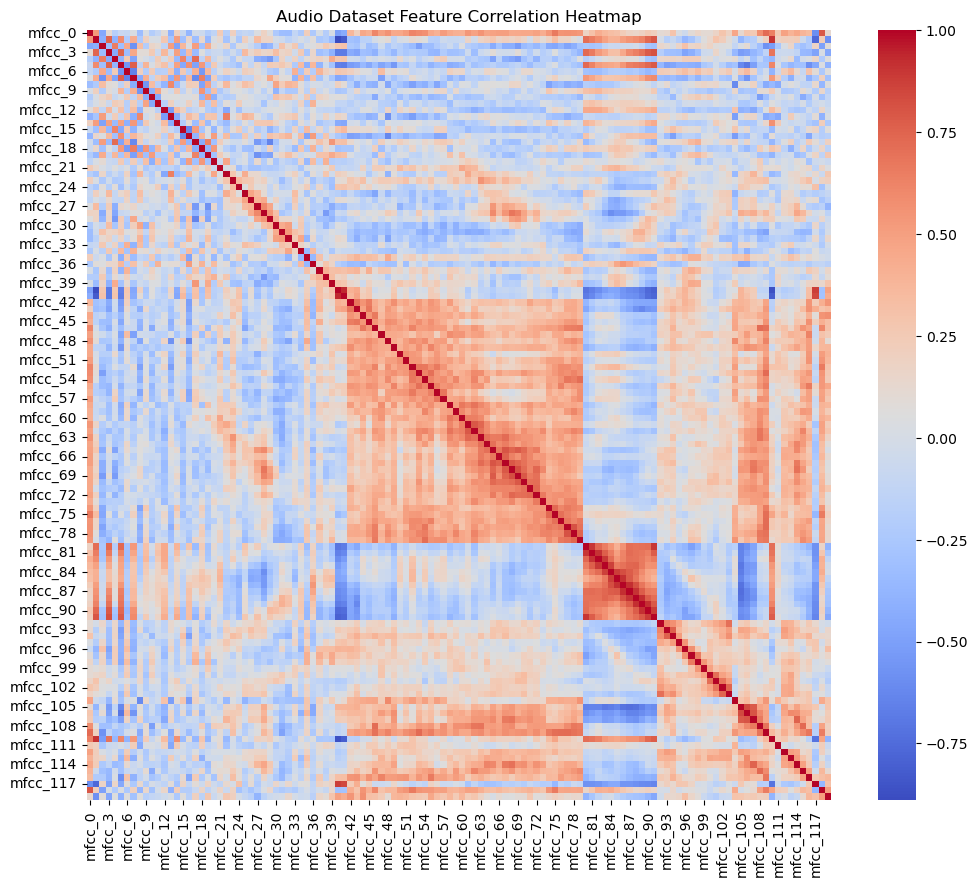

In [30]:
df_heatmap = df_Audio.drop(columns=['id', 'emotion'])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
correlation_matrix = df_heatmap.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Audio Dataset Feature Correlation Heatmap')
plt.show()

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 1. Create a copy so we don't mess up the original data
target_dummies = pd.get_dummies(df_Audio['emotion'], prefix='target')

df_Audio = df_Audio.drop(columns=['id', 'emotion'])

df_corr = pd.concat([df_Audio, target_dummies], axis=1)

corr_matrix = df_corr.corr()

feature_cols = df_Audio.columns
target_cols = target_dummies.columns

target_correlations = corr_matrix.loc[feature_cols, target_cols].abs()
max_audio_score = target_correlations.max(axis=1)

features_to_drop = max_audio_score[max_audio_score < 0.2 ].index.tolist()
print(f"Dropping {len(features_to_drop)} features with low correlation to targets.")

df_Audio = df_Audio.drop(columns=features_to_drop)

Dropping 14 features with low correlation to targets.


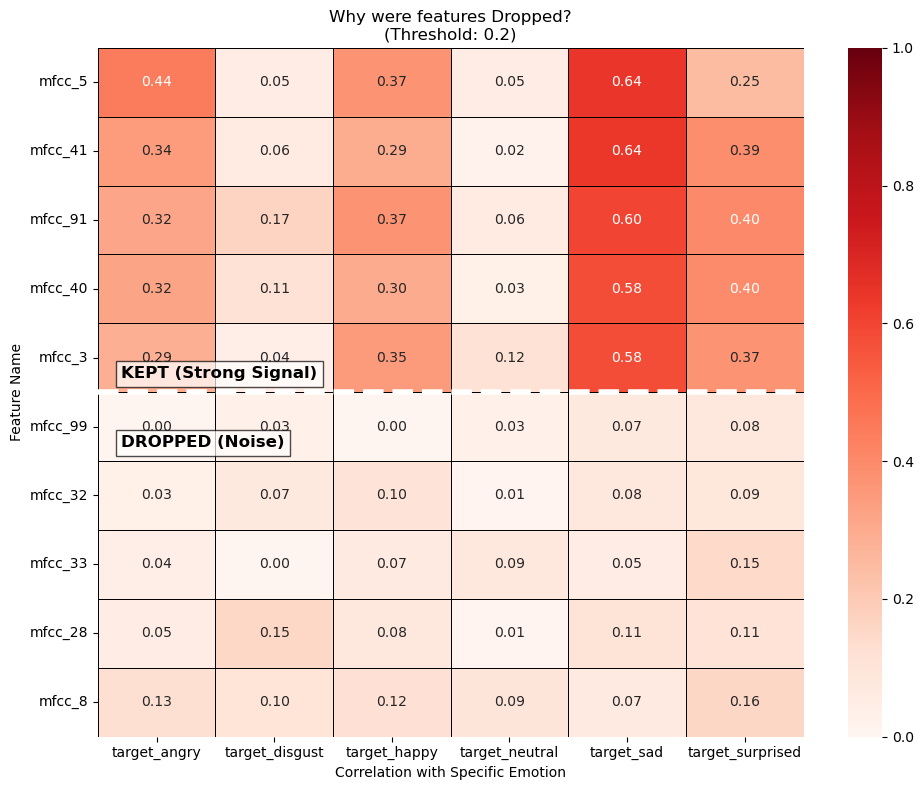

In [32]:
kept_features_audio = max_audio_score[max_audio_score >= 0.2].sort_values(ascending=False).head(5).index.tolist()
dropped_features_audio = max_audio_score[max_audio_score < 0.2].sort_values(ascending=True).head(5).index.tolist()
features_to_plot_audio = kept_features_audio + dropped_features_audio

plot_data_audio = target_correlations.loc[features_to_plot_audio]

plt.figure(figsize=(10, 8))
sns.heatmap(
        plot_data_audio, 
        annot=True,       # Show the numbers
        fmt=".2f",        # 2 decimal places
        cmap='Reds',  # Red = High, Blue = Low
        vmin=0, vmax=1,   # Scale from 0 to 1
        linewidths=0.5,
        linecolor='black'
    )

plt.axhline(len(kept_features_audio), color='white', linewidth=4, linestyle='--')
plt.text(0.2, len(kept_features_audio) - 0.2, "KEPT (Strong Signal)", color='black', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
plt.text(0.2, len(kept_features_audio) + 0.8, "DROPPED (Noise)", color='black', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))

plt.title(f"Why were features Dropped?\n(Threshold: {0.2})")
plt.xlabel("Correlation with Specific Emotion")
plt.ylabel("Feature Name")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [33]:
corr_matrix = df_Audio.corr().abs()

mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper = corr_matrix.where(mask)

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"✅ Dropped {len(to_drop)} redundant features.")
df_Audio = df_Audio.drop(columns=to_drop)

✅ Dropped 0 redundant features.


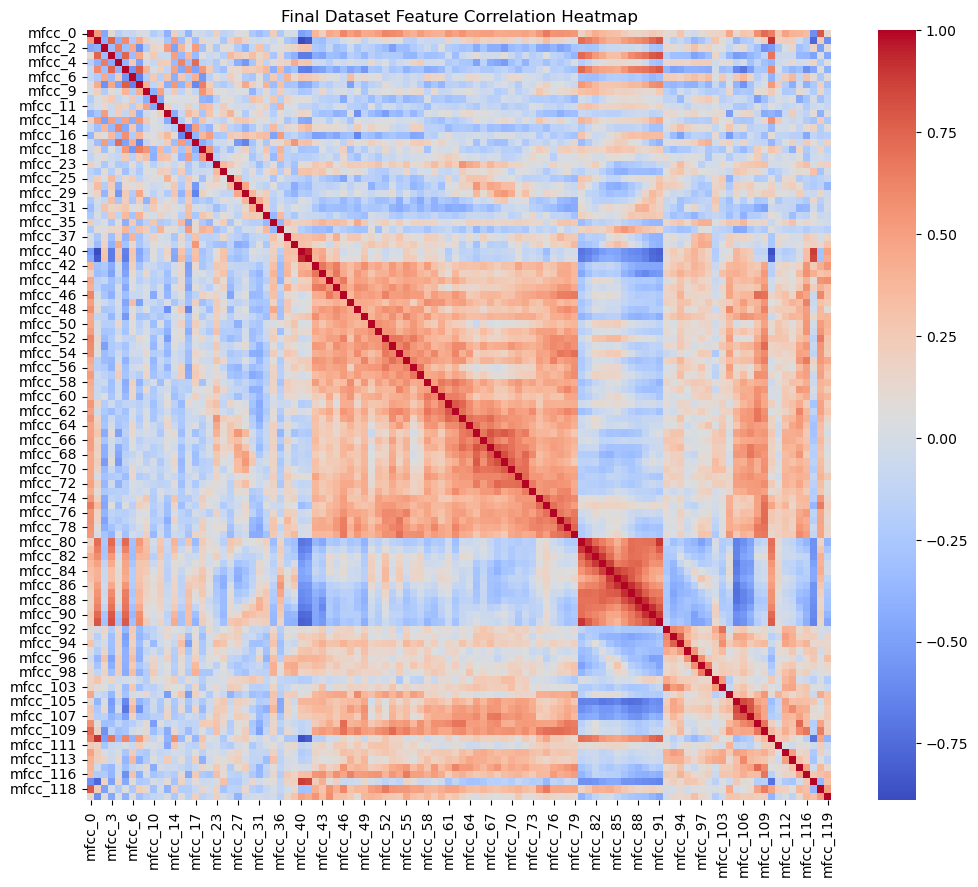

In [34]:
#df_Audio heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
correlation_matrix = df_Audio.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Final Dataset Feature Correlation Heatmap')
plt.show()

In [35]:
df_Audio['emotion'] = target_dummies.idxmax(axis=1).str.replace('target_', '')
print(df_Audio.head())

       mfcc_0      mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5  \
0 -513.561768   49.494762 -16.199219   2.798029   1.335076   1.880273   
1 -573.954712   56.785313  -2.850954  15.505120   2.225241   4.380421   
2 -367.438049  141.136444 -12.092526  33.898346  -6.131912  18.025145   
3 -460.852875   82.447716  -8.276977  26.723400  -1.088647   0.521629   
4 -399.324219   56.620792  -8.664677  12.136850 -11.232705  -0.186267   

     mfcc_6     mfcc_7    mfcc_9   mfcc_10  ...   mfcc_110  mfcc_111  \
0  2.706469  -0.336792 -4.602480  4.788983  ...  21.698259  5.292188   
1 -1.999681   1.939196  0.526952 -0.447507  ...  24.924229  5.566283   
2  5.908717   6.545364  3.470748 -0.755869  ...  53.948728  5.163398   
3  5.090024  -0.918464 -6.530668  6.337666  ...  37.995034  4.241491   
4  9.762609 -12.915164 -3.045569  5.455151  ...  32.399002  3.483600   

   mfcc_112  mfcc_113  mfcc_115  mfcc_116   mfcc_117  mfcc_118  mfcc_119  \
0  2.396936  3.418919  3.028578  4.411795  15.687550

# Train and Test Split

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

X=df_final.drop(columns=['emotion'])
y=df_final['emotion']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=df_final['emotion']
)


In [37]:
X_audio=df_Audio.drop(columns=['emotion'])
y_audio=df_Audio['emotion']

scaler = StandardScaler()
X_scaled_audio = scaler.fit_transform(X_audio)

X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(
    X_scaled_audio,
    y_audio,
    test_size=0.2,
    random_state=42,
    stratify=df_Audio['emotion']
)


# Decision Tree

🌳 Tuning Decision Tree Depth...
   Depth 1: Train=0.46, Test=0.44
   Depth 3: Train=0.60, Test=0.58
   Depth 5: Train=0.72, Test=0.70
   Depth 7: Train=0.84, Test=0.80
   Depth 10: Train=0.97, Test=0.89
   Depth 15: Train=1.00, Test=0.90
   Depth 20: Train=1.00, Test=0.90
   Depth 30: Train=1.00, Test=0.90


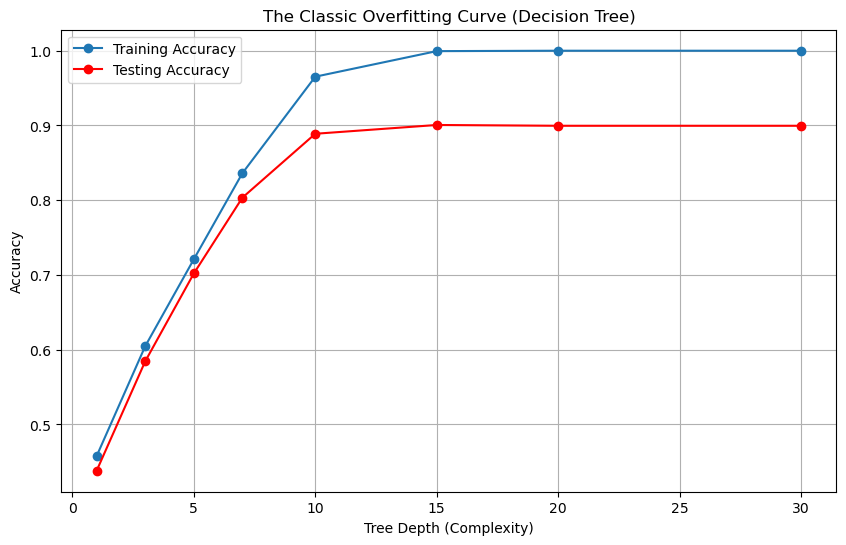

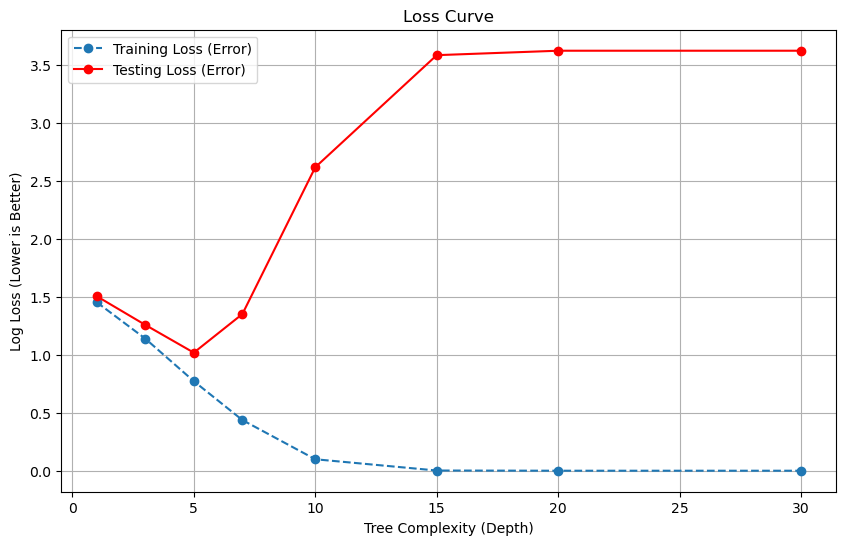

✅ Best Model Saved: best_tree_depth_15.pkl (Accuracy: 90.06%)


In [38]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# visualize loss
train_losses = []
test_losses = []
# Lists to store results
train_scores = []
test_scores = []
depths = [1, 3, 5, 7, 10, 15, 20, 30]

print("🌳 Tuning Decision Tree Depth...")

best_acc = 0.0
best_model = None
best_depth = 0

for d in depths:
    # 1. Create Model with specific depth
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    
    # 2. Train
    clf.fit(X_train, y_train)
    
    # 3. Measure
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    
    y_train_probs = clf.predict_proba(X_train)
    y_test_probs = clf.predict_proba(X_test)

    loss_train = log_loss(y_train, y_train_probs)
    loss_test = log_loss(y_test, y_test_probs)

    train_losses.append(loss_train)
    test_losses.append(loss_test)

    train_scores.append(train_acc)
    test_scores.append(test_acc)
    
    print(f"   Depth {d}: Train={train_acc:.2f}, Test={test_acc:.2f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = clf
        best_depth = d

# 4. PLOT THE "OVERFITTING" CURVE
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Training Accuracy', marker='o')
plt.plot(depths, test_scores, label='Testing Accuracy', marker='o', color='red')
plt.title('The Classic Overfitting Curve (Decision Tree)')
plt.xlabel('Tree Depth (Complexity)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss Curve

plt.figure(figsize=(10, 6))
plt.plot(depths, train_losses, label='Training Loss (Error)', marker='o', linestyle='--')
plt.plot(depths, test_losses, label='Testing Loss (Error)', marker='o', color='red')
plt.title('Loss Curve')
plt.xlabel('Tree Complexity (Depth)')
plt.ylabel('Log Loss (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()

filename = f"best_tree_depth_{best_depth}.pkl"
joblib.dump(best_model, filename)
print(f"✅ Best Model Saved: {filename} (Accuracy: {best_acc:.2%})")

🌳 Tuning Decision Tree Depth...
   Depth 1: Train=0.46, Test=0.44
   Depth 3: Train=0.55, Test=0.50
   Depth 5: Train=0.75, Test=0.72
   Depth 7: Train=0.83, Test=0.78
   Depth 10: Train=0.90, Test=0.85
   Depth 15: Train=0.91, Test=0.85
   Depth 20: Train=0.91, Test=0.85
   Depth 30: Train=0.91, Test=0.85


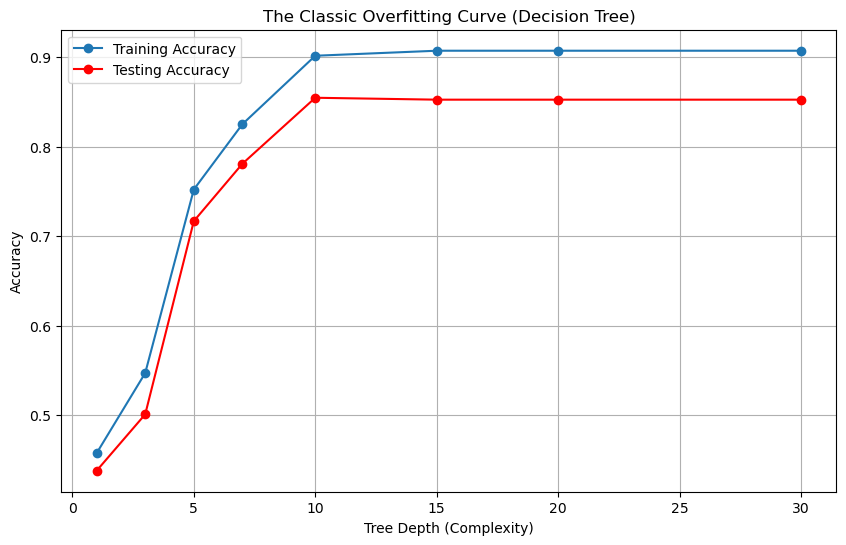

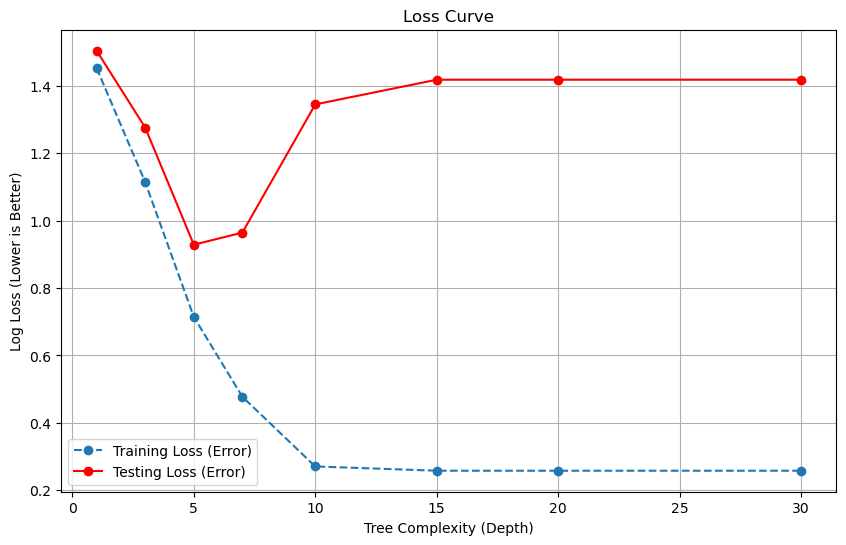

✅ Best Model Saved: best_reg_tree_depth_10.pkl (Accuracy: 85.47%)


In [39]:
train_losses = []
test_losses = []
# Lists to store results
train_scores = []
test_scores = []
depths = [1, 3, 5, 7, 10, 15, 20, 30]

best_acc = 0.0
best_model = None
best_depth = 0

print("🌳 Tuning Decision Tree Depth...")

for d in depths:
    # 1. Create Model with specific depth
    reg_tree = DecisionTreeClassifier(
    max_depth= d, 
    min_samples_leaf=10,  # <--- STRONG REGULARIZER
    ccp_alpha=0.005,    # <--- PRUNING TO AVOID OVERFITTING
    criterion='entropy',
    random_state=42
)
    
    # 2. Train
    reg_tree.fit(X_train, y_train)
    
    # 3. Measure
    train_acc = accuracy_score(y_train, reg_tree.predict(X_train))
    test_acc = accuracy_score(y_test, reg_tree.predict(X_test))
    
    y_train_probs = reg_tree.predict_proba(X_train)
    y_test_probs = reg_tree.predict_proba(X_test)

    loss_train = log_loss(y_train, y_train_probs)
    loss_test = log_loss(y_test, y_test_probs)

    train_losses.append(loss_train)
    test_losses.append(loss_test)

    train_scores.append(train_acc)
    test_scores.append(test_acc)
    
    print(f"   Depth {d}: Train={train_acc:.2f}, Test={test_acc:.2f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = clf
        best_depth = d

# 4. PLOT THE "OVERFITTING" CURVE
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Training Accuracy', marker='o')
plt.plot(depths, test_scores, label='Testing Accuracy', marker='o', color='red')
plt.title('The Classic Overfitting Curve (Decision Tree)')
plt.xlabel('Tree Depth (Complexity)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss Curve

plt.figure(figsize=(10, 6))
plt.plot(depths, train_losses, label='Training Loss (Error)', marker='o', linestyle='--')
plt.plot(depths, test_losses, label='Testing Loss (Error)', marker='o', color='red')
plt.title('Loss Curve')
plt.xlabel('Tree Complexity (Depth)')
plt.ylabel('Log Loss (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()

if best_model is not None:
    filename = f"best_reg_tree_depth_{best_depth}.pkl"
    joblib.dump(best_model, filename)
    print(f"✅ Best Model Saved: {filename} (Accuracy: {best_acc:.2%})")

🌳 Tuning Decision Tree Depth...
   Depth 1: Train=0.66, Test=0.58
   Depth 3: Train=0.87, Test=0.53
   Depth 5: Train=0.99, Test=0.47
   Depth 7: Train=1.00, Test=0.47
   Depth 10: Train=1.00, Test=0.47
   Depth 15: Train=1.00, Test=0.47
   Depth 20: Train=1.00, Test=0.47
   Depth 30: Train=1.00, Test=0.47


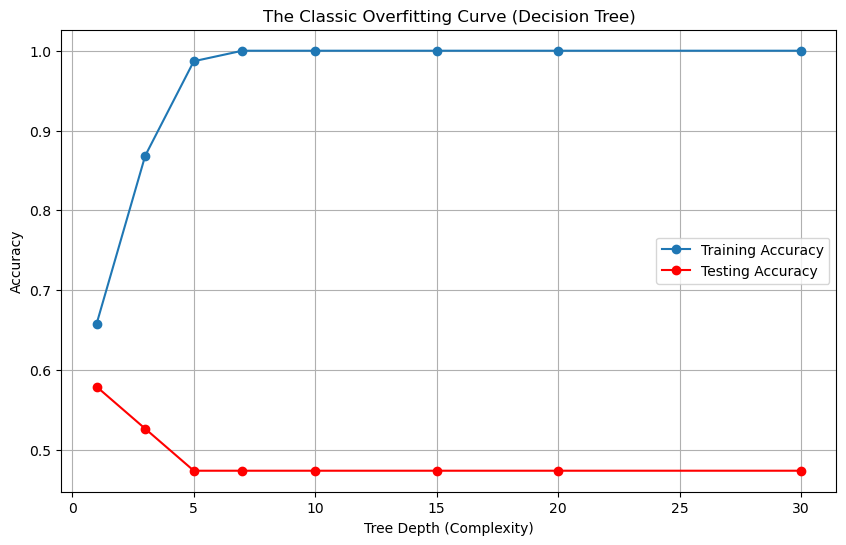

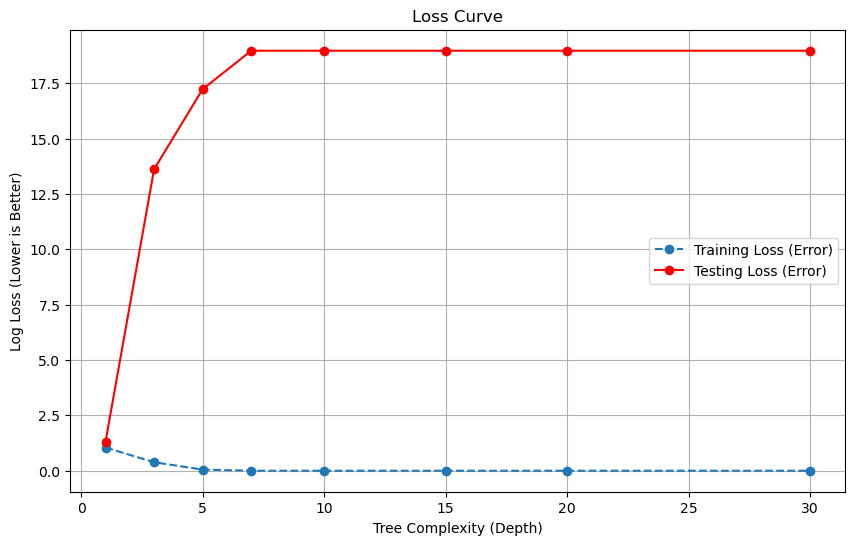

✅ Best Model Saved: best_tree_depth_1_audio.pkl (Accuracy: 85.26%)


In [40]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# visualize loss
train_losses_audio = []
test_losses_audio = []
# Lists to store results
train_scores_audio = []
test_scores_audio = []
depths_audio = [1, 3, 5, 7, 10, 15, 20, 30]

best_acc = 0.0
best_model = None
best_depth = 0

print("🌳 Tuning Decision Tree Depth...")

for d in depths_audio:
    # 1. Create Model with specific depth
    clf_audio = DecisionTreeClassifier(max_depth=d, random_state=42)
    
    # 2. Train
    clf_audio.fit(X_train_audio, y_train_audio)
    
    # 3. Measure
    train_acc_audio = accuracy_score(y_train_audio, clf_audio.predict(X_train_audio))
    test_acc_audio = accuracy_score(y_test_audio, clf_audio.predict(X_test_audio))
    
    y_train_audio_probs = clf_audio.predict_proba(X_train_audio)
    y_test_probs_audio = clf_audio.predict_proba(X_test_audio)

    loss_train_audio = log_loss(y_train_audio, y_train_audio_probs)
    loss_test_audio = log_loss(y_test_audio, y_test_probs_audio)

    train_losses_audio.append(loss_train_audio)
    test_losses_audio.append(loss_test_audio)

    train_scores_audio.append(train_acc_audio)
    test_scores_audio.append(test_acc_audio)
    
    print(f"   Depth {d}: Train={train_acc_audio:.2f}, Test={test_acc_audio:.2f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = clf
        best_depth = d

# 4. PLOT THE "OVERFITTING" CURVE
plt.figure(figsize=(10, 6))
plt.plot(depths_audio, train_scores_audio, label='Training Accuracy', marker='o')
plt.plot(depths_audio, test_scores_audio, label='Testing Accuracy', marker='o', color='red')
plt.title('The Classic Overfitting Curve (Decision Tree)')
plt.xlabel('Tree Depth (Complexity)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss Curve

plt.figure(figsize=(10, 6))
plt.plot(depths_audio, train_losses_audio, label='Training Loss (Error)', marker='o', linestyle='--')
plt.plot(depths_audio, test_losses_audio, label='Testing Loss (Error)', marker='o', color='red')
plt.title('Loss Curve')
plt.xlabel('Tree Complexity (Depth)')
plt.ylabel('Log Loss (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()

if best_model is not None:
    filename = f"best_tree_depth_{best_depth}_audio.pkl"
    joblib.dump(best_model, filename)
    print(f"✅ Best Model Saved: {filename} (Accuracy: {best_acc:.2%})")

🌳 Tuning Decision Tree Depth...
   Depth 1: Train=0.66, Test=0.58
   Depth 3: Train=0.76, Test=0.58
   Depth 5: Train=0.76, Test=0.58
   Depth 7: Train=0.76, Test=0.58
   Depth 10: Train=0.76, Test=0.58
   Depth 15: Train=0.76, Test=0.58
   Depth 20: Train=0.76, Test=0.58
   Depth 30: Train=0.76, Test=0.58


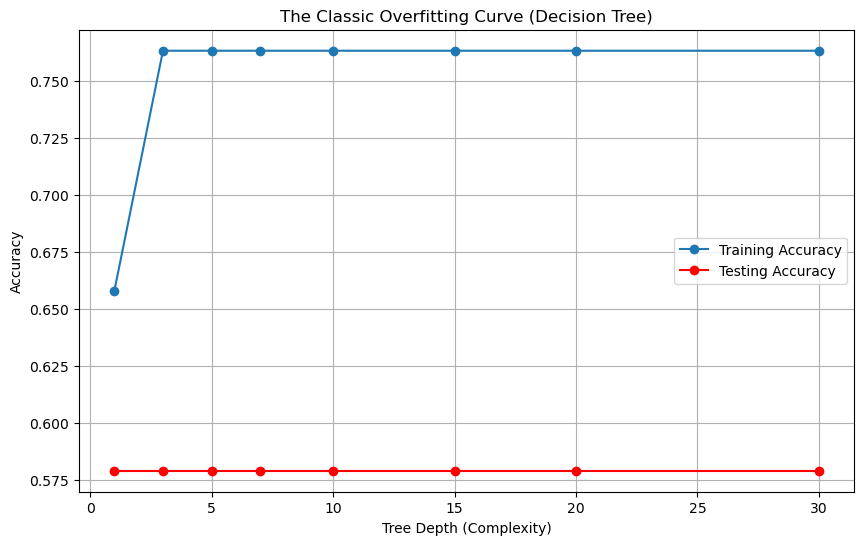

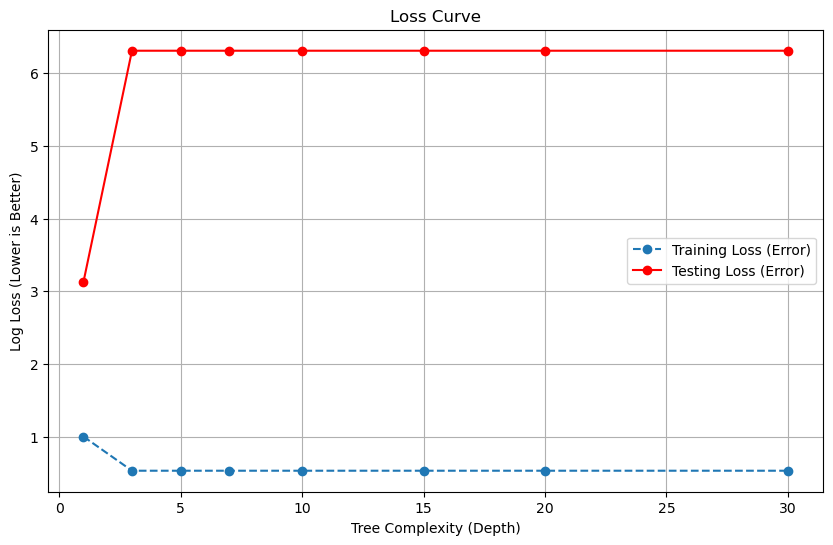

✅ Best Model Saved: best_reg_tree_depth_1_audio.pkl (Accuracy: 85.26%)


In [41]:



train_losses_audio = []
test_losses_audio = []
# Lists to store results
train_scores_audio = []
test_scores_audio = []
depths_audio = [1, 3, 5, 7, 10, 15, 20, 30]

best_acc = 0.0
best_model = None
best_depth = 0

print("🌳 Tuning Decision Tree Depth...")

for d in depths_audio:
    # 1. Create Model with specific depth
    reg_tree_audio = DecisionTreeClassifier(
    max_depth= d, 
    min_samples_leaf=10,  # <--- STRONG REGULARIZER
    ccp_alpha=0.05,    # <--- PRUNING TO AVOID OVERFITTING
    criterion='entropy',
    random_state=42
)
    
    # 2. Train
    reg_tree_audio.fit(X_train_audio, y_train_audio)
    
    # 3. Measure
    train_acc_audio = accuracy_score(y_train_audio, reg_tree_audio.predict(X_train_audio))
    test_acc_audio = accuracy_score(y_test_audio, reg_tree_audio.predict(X_test_audio))
    
    y_train_probs_audio = reg_tree_audio.predict_proba(X_train_audio)
    y_test_probs_audio = reg_tree_audio.predict_proba(X_test_audio)

    loss_train_audio = log_loss(y_train_audio, y_train_probs_audio)
    loss_test_audio = log_loss(y_test_audio, y_test_probs_audio)

    train_losses_audio.append(loss_train_audio)
    test_losses_audio.append(loss_test_audio)

    train_scores_audio.append(train_acc_audio)
    test_scores_audio.append(test_acc_audio)
    
    print(f"   Depth {d}: Train={train_acc_audio:.2f}, Test={test_acc_audio:.2f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = clf
        best_depth = d

# 4. PLOT THE "OVERFITTING" CURVE
plt.figure(figsize=(10, 6))
plt.plot(depths_audio, train_scores_audio, label='Training Accuracy', marker='o')
plt.plot(depths_audio, test_scores_audio, label='Testing Accuracy', marker='o', color='red')
plt.title('The Classic Overfitting Curve (Decision Tree)')
plt.xlabel('Tree Depth (Complexity)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss Curve

plt.figure(figsize=(10, 6))
plt.plot(depths_audio, train_losses_audio, label='Training Loss (Error)', marker='o', linestyle='--')
plt.plot(depths_audio, test_losses_audio, label='Testing Loss (Error)', marker='o', color='red')
plt.title('Loss Curve')
plt.xlabel('Tree Complexity (Depth)')
plt.ylabel('Log Loss (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()

if best_model is not None:
    filename = f"best_reg_tree_depth_{best_depth}_audio.pkl"
    joblib.dump(best_model, filename)
    print(f"✅ Best Model Saved: {filename} (Accuracy: {best_acc:.2%})")

# KNN

🏷️ Class Mapping: {'angry': 0, 'disgust': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprised': 5}
   (Note: Check which number 'Angry' is. You might need this for your App!)

📍 Tuning Normal KNN (Video)...
   k=1: Train Acc=1.00 | Test Acc=0.99 | Test Loss=0.54
   k=3: Train Acc=1.00 | Test Acc=0.98 | Test Loss=0.30
   k=5: Train Acc=1.00 | Test Acc=0.98 | Test Loss=0.21
   k=7: Train Acc=1.00 | Test Acc=0.97 | Test Loss=0.16
   k=10: Train Acc=1.00 | Test Acc=0.96 | Test Loss=0.18
   k=15: Train Acc=1.00 | Test Acc=0.95 | Test Loss=0.22
   k=20: Train Acc=1.00 | Test Acc=0.94 | Test Loss=0.21
   k=30: Train Acc=1.00 | Test Acc=0.92 | Test Loss=0.26
   k=40: Train Acc=1.00 | Test Acc=0.90 | Test Loss=0.26
   k=50: Train Acc=1.00 | Test Acc=0.88 | Test Loss=0.30


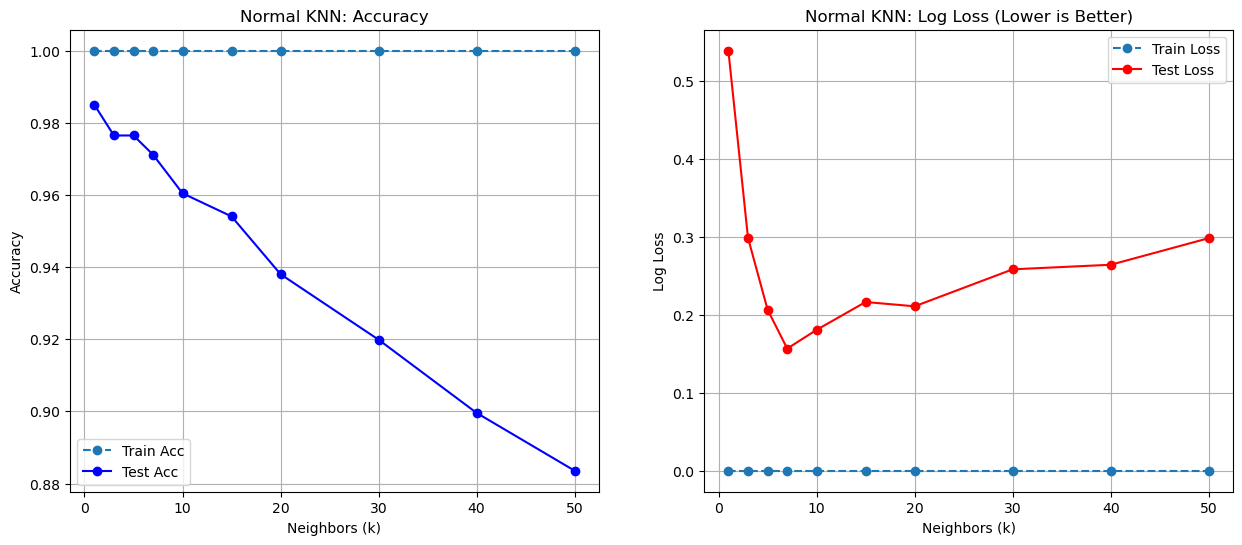

✅ Best Normal k: 1


['knn_emotion_video_normal.pkl']

In [42]:

from sklearn.neighbors import KNeighborsClassifier


# --- 1. DATA FIX: ENCODE LABELS ---
# This converts 'angry', 'neutral' -> 0, 1 to prevent the ValueError
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("🏷️ Class Mapping:", dict(zip(le.classes_, range(len(le.classes_)))))
print("   (Note: Check which number 'Angry' is. You might need this for your App!)")

# --- 2. SETUP ---
neighbors = [1, 3, 5, 7, 10, 15, 20, 30, 40, 50]

# Global lists to store results for Cell 2
global test_acc_normal, test_loss_normal
train_acc_normal, test_acc_normal = [], []
train_loss_normal, test_loss_normal = [], []

print("\n📍 Tuning Normal KNN (Video)...")

for k in neighbors:
    # NORMAL MODEL: Distance weights + Euclidean
    clf = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2, n_jobs=-1)
    clf.fit(X_train, y_train_enc)
    
    # Calculate Probabilities for Log Loss
    y_probs_train = clf.predict_proba(X_train)
    y_probs_test = clf.predict_proba(X_test)
    
    # Store Metrics
    train_acc_normal.append(accuracy_score(y_train_enc, clf.predict(X_train)))
    test_acc_normal.append(accuracy_score(y_test_enc, clf.predict(X_test)))
    
    train_loss_normal.append(log_loss(y_train_enc, y_probs_train))
    test_loss_normal.append(log_loss(y_test_enc, y_probs_test))
    
    print(f"   k={k}: Train Acc={train_acc_normal[-1]:.2f} | Test Acc={test_acc_normal[-1]:.2f} | Test Loss={test_loss_normal[-1]:.2f}")

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
ax1.plot(neighbors, train_acc_normal, label='Train Acc', marker='o', linestyle='--')
ax1.plot(neighbors, test_acc_normal, label='Test Acc', marker='o', color='blue')
ax1.set_title('Normal KNN: Accuracy')
ax1.set_xlabel('Neighbors (k)')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(neighbors, train_loss_normal, label='Train Loss', marker='o', linestyle='--')
ax2.plot(neighbors, test_loss_normal, label='Test Loss', marker='o', color='red')
ax2.set_title('Normal KNN: Log Loss (Lower is Better)')
ax2.set_xlabel('Neighbors (k)')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# Save Best Normal Model
best_idx = np.argmax(test_acc_normal)
print(f"✅ Best Normal k: {neighbors[best_idx]}")

# Save the encoder too, so we can decode '0' back to 'angry' later
joblib.dump(le, 'label_encoder.pkl') 

# Train and save best model
best_normal = KNeighborsClassifier(n_neighbors=neighbors[best_idx], weights='distance', n_jobs=-1)
best_normal.fit(X_train, y_train_enc)
joblib.dump(best_normal, 'knn_emotion_video_normal.pkl')

🛡️ Tuning Robust KNN (Video)...
   k=1: Train Acc=1.00 | Test Acc=0.98 | Test Loss=0.62
   k=3: Train Acc=0.99 | Test Acc=0.97 | Test Loss=0.53
   k=5: Train Acc=0.98 | Test Acc=0.97 | Test Loss=0.22
   k=7: Train Acc=0.97 | Test Acc=0.95 | Test Loss=0.25
   k=10: Train Acc=0.95 | Test Acc=0.94 | Test Loss=0.26
   k=15: Train Acc=0.93 | Test Acc=0.90 | Test Loss=0.23
   k=20: Train Acc=0.90 | Test Acc=0.88 | Test Loss=0.28
   k=30: Train Acc=0.89 | Test Acc=0.87 | Test Loss=0.34
   k=40: Train Acc=0.87 | Test Acc=0.85 | Test Loss=0.36
   k=50: Train Acc=0.85 | Test Acc=0.85 | Test Loss=0.41


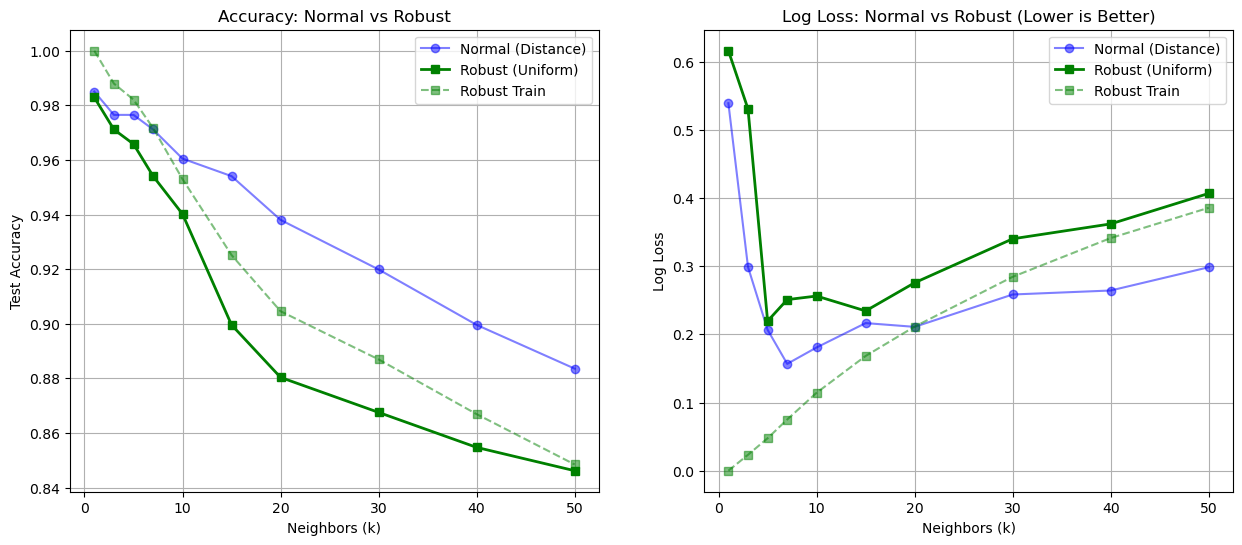

✅ Best Robust k: 1
💾 Saved final model as 'knn_emotion_model.pkl'


In [43]:
# Check if Cell 1 was run
if 'test_loss_normal' not in globals():
    print("⚠️ STOP: Run Cell 1 first to define the data and normal scores!")
else:
    train_acc_robust = []
    train_loss_robust = [] 
    test_acc_robust = []
    test_loss_robust = []
    
    print("🛡️ Tuning Robust KNN (Video)...")

    for k in neighbors:
        # ROBUST MODEL: Uniform weights + Manhattan
        # We use y_train_enc to avoid the ValueError
        clf = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=1, n_jobs=-1)
        clf.fit(X_train, y_train_enc)
        
        y_probs_test = clf.predict_proba(X_test)
        
        # Store metrics
        train_acc_robust.append(accuracy_score(y_train_enc, clf.predict(X_train)))
        train_loss_robust.append(log_loss(y_train_enc, clf.predict_proba(X_train)))
        test_acc_robust.append(accuracy_score(y_test_enc, clf.predict(X_test)))
        test_loss_robust.append(log_loss(y_test_enc, y_probs_test))
        
        # --- NEW: PRINT THE RESULTS ---
        print(f"   k={k}: Train Acc={train_acc_robust[-1]:.2f} | Test Acc={test_acc_robust[-1]:.2f} | Test Loss={test_loss_robust[-1]:.2f}")

    # --- COMPARISON PLOTS ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # 1. ACCURACY COMPARISON
    ax1.plot(neighbors, test_acc_normal, label='Normal (Distance)', marker='o', color='blue', alpha=0.5)
    ax1.plot(neighbors, test_acc_robust, label='Robust (Uniform)', marker='s', color='green', linewidth=2)
    ax1.plot(neighbors, train_acc_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
    ax1.set_title('Accuracy: Normal vs Robust')
    ax1.set_xlabel('Neighbors (k)')
    ax1.set_ylabel('Test Accuracy')
    ax1.legend()
    ax1.grid(True)

    # 2. LOSS COMPARISON
    ax2.plot(neighbors, test_loss_normal, label='Normal (Distance)', marker='o', color='blue', alpha=0.5)
    ax2.plot(neighbors, test_loss_robust, label='Robust (Uniform)', marker='s', color='green', linewidth=2)
    ax2.plot(neighbors, train_loss_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
    ax2.set_title('Log Loss: Normal vs Robust (Lower is Better)')
    ax2.set_xlabel('Neighbors (k)')
    ax2.set_ylabel('Log Loss')
    ax2.legend()
    ax2.grid(True)

    plt.show()

    # Save Best Robust Model
    best_idx_r = np.argmax(test_acc_robust)
    print(f"✅ Best Robust k: {neighbors[best_idx_r]}")
    
    final_robust_model = KNeighborsClassifier(n_neighbors=neighbors[best_idx_r], weights='uniform', p=1, n_jobs=-1)
    final_robust_model.fit(X_train, y_train_enc)
    joblib.dump(final_robust_model, 'knn_emotion_model.pkl')
    print("💾 Saved final model as 'knn_emotion_model.pkl'")

🎤 Audio Class Mapping: {'angry': 0, 'disgust': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprised': 5}

📍 Tuning Normal KNN (Audio)...
   k=1: Train Acc=1.00 | Test Acc=0.63 | Test Loss=13.28
   k=3: Train Acc=1.00 | Test Acc=0.68 | Test Loss=5.98
   k=5: Train Acc=1.00 | Test Acc=0.63 | Test Loss=6.10
   k=7: Train Acc=1.00 | Test Acc=0.68 | Test Loss=4.37
   k=10: Train Acc=1.00 | Test Acc=0.74 | Test Loss=4.45
   k=15: Train Acc=1.00 | Test Acc=0.68 | Test Loss=4.47
   k=20: Train Acc=1.00 | Test Acc=0.58 | Test Loss=4.52
   k=30: Train Acc=1.00 | Test Acc=0.53 | Test Loss=2.88
   k=40: Train Acc=1.00 | Test Acc=0.53 | Test Loss=1.17


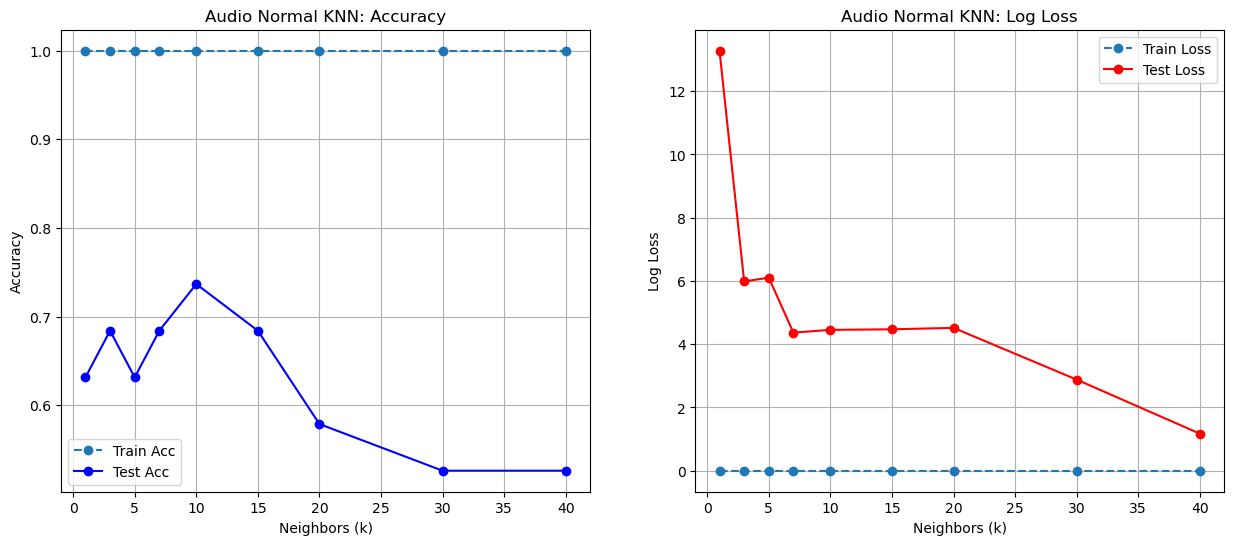

✅ Best Normal Audio k: 10


['knn_emotion_audio_normal.pkl']

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder

# --- 1. DATA FIX: ENCODE AUDIO LABELS ---
# We use a separate encoder for audio just in case the labels differ slightly
le_audio = LabelEncoder()
y_train_audio_enc = le_audio.fit_transform(y_train_audio)
y_test_audio_enc = le_audio.transform(y_test_audio)

print("🎤 Audio Class Mapping:", dict(zip(le_audio.classes_, range(len(le_audio.classes_)))))

# --- 2. SETUP ---
# Audio often needs slightly larger 'k' to smooth out noise
neighbors_audio = [1, 3, 5, 7, 10, 15, 20, 30, 40]

# Global lists for Cell 2
global test_acc_audio_normal, test_loss_audio_normal
train_acc_audio_normal, test_acc_audio_normal = [], []
train_loss_audio_normal, test_loss_audio_normal = [], []

print("\n📍 Tuning Normal KNN (Audio)...")

for k in neighbors_audio:
    # NORMAL MODEL: Distance weights + Euclidean
    clf = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2, n_jobs=-1)
    clf.fit(X_train_audio, y_train_audio_enc)
    
    # Calculate Probabilities
    y_probs_train = clf.predict_proba(X_train_audio)
    y_probs_test = clf.predict_proba(X_test_audio)
    
    # Store Metrics
    train_acc_audio_normal.append(accuracy_score(y_train_audio_enc, clf.predict(X_train_audio)))
    test_acc_audio_normal.append(accuracy_score(y_test_audio_enc, clf.predict(X_test_audio)))
    
    train_loss_audio_normal.append(log_loss(y_train_audio_enc, y_probs_train))
    test_loss_audio_normal.append(log_loss(y_test_audio_enc, y_probs_test))
    
    print(f"   k={k}: Train Acc={train_acc_audio_normal[-1]:.2f} | Test Acc={test_acc_audio_normal[-1]:.2f} | Test Loss={test_loss_audio_normal[-1]:.2f}")

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
ax1.plot(neighbors_audio, train_acc_audio_normal, label='Train Acc', marker='o', linestyle='--')
ax1.plot(neighbors_audio, test_acc_audio_normal, label='Test Acc', marker='o', color='blue')
ax1.set_title('Audio Normal KNN: Accuracy')
ax1.set_xlabel('Neighbors (k)')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(neighbors_audio, train_loss_audio_normal, label='Train Loss', marker='o', linestyle='--')
ax2.plot(neighbors_audio, test_loss_audio_normal, label='Test Loss', marker='o', color='red')
ax2.set_title('Audio Normal KNN: Log Loss')
ax2.set_xlabel('Neighbors (k)')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# Save Best Normal Model & Encoder
best_idx_a = np.argmax(test_acc_audio_normal)
print(f"✅ Best Normal Audio k: {neighbors_audio[best_idx_a]}")

joblib.dump(le_audio, 'label_encoder_audio.pkl') 

best_audio_normal = KNeighborsClassifier(n_neighbors=neighbors_audio[best_idx_a], weights='distance', n_jobs=-1)
best_audio_normal.fit(X_train_audio, y_train_audio_enc)
joblib.dump(best_audio_normal, 'knn_emotion_audio_normal.pkl')

🛡️ Tuning Robust KNN (Audio)...
   k=1: Train Acc=1.00 | Test Acc=0.68 | Test Loss=11.38
   k=3: Train Acc=0.84 | Test Acc=0.63 | Test Loss=7.83
   k=5: Train Acc=0.76 | Test Acc=0.58 | Test Loss=6.18
   k=7: Train Acc=0.74 | Test Acc=0.68 | Test Loss=6.27
   k=10: Train Acc=0.67 | Test Acc=0.63 | Test Loss=4.49
   k=15: Train Acc=0.66 | Test Acc=0.63 | Test Loss=4.48
   k=20: Train Acc=0.58 | Test Acc=0.58 | Test Loss=4.54
   k=30: Train Acc=0.50 | Test Acc=0.53 | Test Loss=4.64
   k=40: Train Acc=0.45 | Test Acc=0.47 | Test Loss=1.32


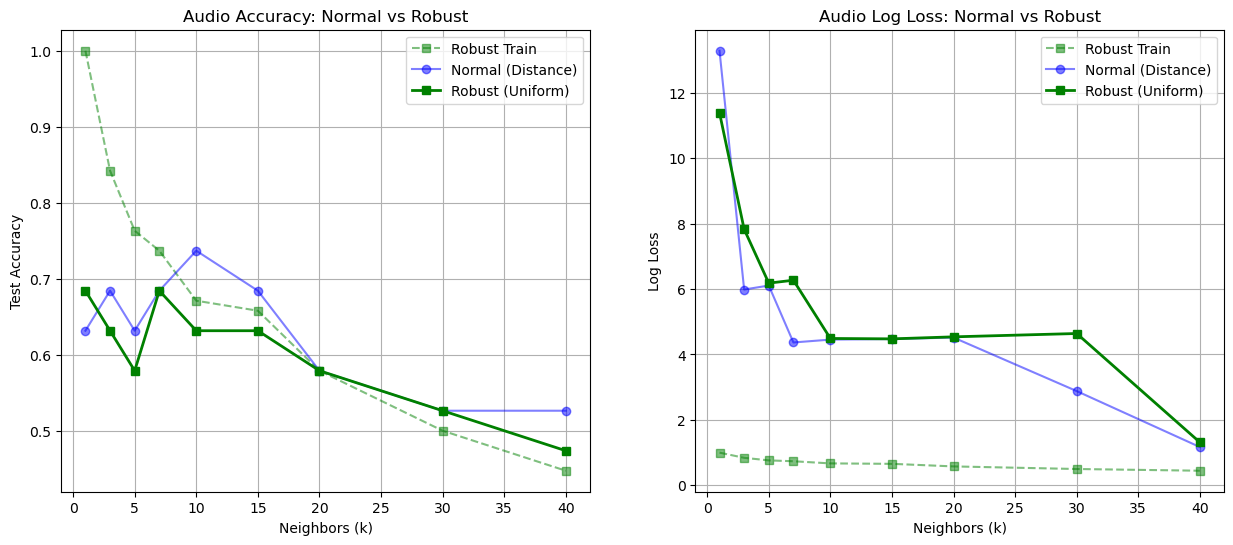

✅ Best Robust Audio k: 1
💾 Saved final audio model as 'knn_emotion_audio_model.pkl'


In [45]:
# Check if Cell 1 was run
if 'test_loss_audio_normal' not in globals():
    print("⚠️ STOP: Run Audio Cell 1 first!")
else:
    train_acc_audio_robust = []
    test_acc_audio_robust = []
    test_loss_audio_robust = []
    
    print("🛡️ Tuning Robust KNN (Audio)...")

    for k in neighbors_audio:
        # ROBUST MODEL: Uniform weights + Manhattan
        # Using encoded labels
        clf = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=1, n_jobs=-1)
        clf.fit(X_train_audio, y_train_audio_enc)
        
        y_probs_test = clf.predict_proba(X_test_audio)
        
        # Store metrics
        train_acc_audio_robust.append(accuracy_score(y_train_audio_enc, clf.predict(X_train_audio)))
        test_acc_audio_robust.append(accuracy_score(y_test_audio_enc, clf.predict(X_test_audio)))
        test_loss_audio_robust.append(log_loss(y_test_audio_enc, y_probs_test))
        
        # --- PRINT THE RESULTS ---
        print(f"   k={k}: Train Acc={train_acc_audio_robust[-1]:.2f} | Test Acc={test_acc_audio_robust[-1]:.2f} | Test Loss={test_loss_audio_robust[-1]:.2f}")

    # --- COMPARISON PLOTS ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # 1. ACCURACY COMPARISON
    ax1.plot(neighbors_audio, train_acc_audio_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
    ax1.plot(neighbors_audio, test_acc_audio_normal, label='Normal (Distance)', marker='o', color='blue', alpha=0.5)
    ax1.plot(neighbors_audio, test_acc_audio_robust, label='Robust (Uniform)', marker='s', color='green', linewidth=2)
    ax1.set_title('Audio Accuracy: Normal vs Robust')
    ax1.set_xlabel('Neighbors (k)')
    ax1.set_ylabel('Test Accuracy')
    ax1.legend()
    ax1.grid(True)

    # 2. LOSS COMPARISON
    ax2.plot(neighbors_audio, train_acc_audio_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
    ax2.plot(neighbors_audio, test_loss_audio_normal, label='Normal (Distance)', marker='o', color='blue', alpha=0.5)
    ax2.plot(neighbors_audio, test_loss_audio_robust, label='Robust (Uniform)', marker='s', color='green', linewidth=2)
    ax2.set_title('Audio Log Loss: Normal vs Robust')
    ax2.set_xlabel('Neighbors (k)')
    ax2.set_ylabel('Log Loss')
    ax2.legend()
    ax2.grid(True)

    plt.show()

    # Save Best Robust Model
    best_idx_ar = np.argmax(test_acc_audio_robust)
    print(f"✅ Best Robust Audio k: {neighbors_audio[best_idx_ar]}")
    
    final_robust_audio = KNeighborsClassifier(n_neighbors=neighbors_audio[best_idx_ar], weights='uniform', p=1, n_jobs=-1)
    final_robust_audio.fit(X_train_audio, y_train_audio_enc)
    joblib.dump(final_robust_audio, 'knn_emotion_audio_model.pkl')
    print("💾 Saved final audio model as 'knn_emotion_audio_model.pkl'")

# SVM

📍 Tuning SVM C-Value (Video)...
   C=0.01: Train Acc=0.57 | Test Acc=0.58 | Test Loss=0.71
   C=0.1: Train Acc=0.82 | Test Acc=0.81 | Test Loss=0.46
   C=1: Train Acc=0.92 | Test Acc=0.92 | Test Loss=0.21
   C=10: Train Acc=0.98 | Test Acc=0.96 | Test Loss=0.10
   C=100: Train Acc=1.00 | Test Acc=0.99 | Test Loss=0.06


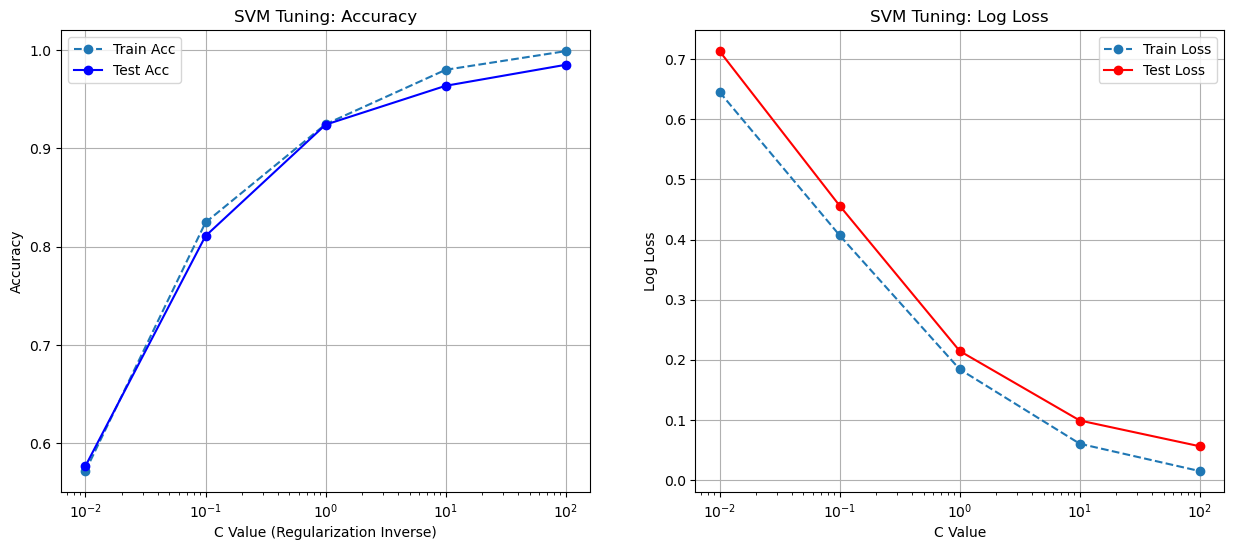

✅ Best SVM C: 100
💾 Saved as 'svm_emotion_video_model.pkl'


In [46]:

from sklearn.svm import SVC


# --- CONFIG ---
# C values are usually logarithmic (powers of 10)
c_values = [0.01, 0.1, 1, 10, 100]

# Global lists to store results for Cell 2
global test_acc_svm_normal, test_loss_svm_normal, train_acc_svm_normal
train_acc_svm_normal, test_acc_svm_normal = [], []
train_loss_svm_normal, test_loss_svm_normal = [], []

print("📍 Tuning SVM C-Value (Video)...")

for c in c_values:
    # 1. Create Model 
    # kernel='rbf' is standard for complex data like faces
    # probability=True is REQUIRED for log_loss and the live app
    clf = SVC(C=c, kernel='rbf', gamma='scale', probability=True, random_state=42)
    
    # 2. Train
    clf.fit(X_train, y_train)
    
    # 3. Measure
    # Predictions
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_probs_train = clf.predict_proba(X_train)
    y_probs_test = clf.predict_proba(X_test)
    
    # Store Metrics
    train_acc_svm_normal.append(accuracy_score(y_train, y_pred_train))
    test_acc_svm_normal.append(accuracy_score(y_test, y_pred_test))
    
    train_loss_svm_normal.append(log_loss(y_train, y_probs_train))
    test_loss_svm_normal.append(log_loss(y_test, y_probs_test))
    
    print(f"   C={c}: Train Acc={train_acc_svm_normal[-1]:.2f} | Test Acc={test_acc_svm_normal[-1]:.2f} | Test Loss={test_loss_svm_normal[-1]:.2f}")

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
ax1.plot(c_values, train_acc_svm_normal, label='Train Acc', marker='o', linestyle='--')
ax1.plot(c_values, test_acc_svm_normal, label='Test Acc', marker='o', color='blue')
ax1.set_xscale('log') # Log scale for C
ax1.set_title('SVM Tuning: Accuracy')
ax1.set_xlabel('C Value (Regularization Inverse)')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(c_values, train_loss_svm_normal, label='Train Loss', marker='o', linestyle='--')
ax2.plot(c_values, test_loss_svm_normal, label='Test Loss', marker='o', color='red')
ax2.set_xscale('log') # Log scale for C
ax2.set_title('SVM Tuning: Log Loss')
ax2.set_xlabel('C Value')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# Save Best Model
best_idx = np.argmax(test_acc_svm_normal)
best_c = c_values[best_idx]
print(f"✅ Best SVM C: {best_c}")

final_svm = SVC(C=best_c, kernel='rbf', gamma='scale', probability=True, random_state=42)
final_svm.fit(X_train, y_train)
joblib.dump(final_svm, 'svm_emotion_video_model.pkl')
print("💾 Saved as 'svm_emotion_video_model.pkl'")

🛡️ Tuning Robust SVM (Gamma Regularization)...
   C=0.01: Train Acc=0.46 | Test Acc=0.46 | Test Loss=0.83
   C=0.1: Train Acc=0.73 | Test Acc=0.73 | Test Loss=0.60
   C=1: Train Acc=0.87 | Test Acc=0.87 | Test Loss=0.37
   C=10: Train Acc=0.95 | Test Acc=0.94 | Test Loss=0.18
   C=100: Train Acc=0.99 | Test Acc=0.97 | Test Loss=0.09


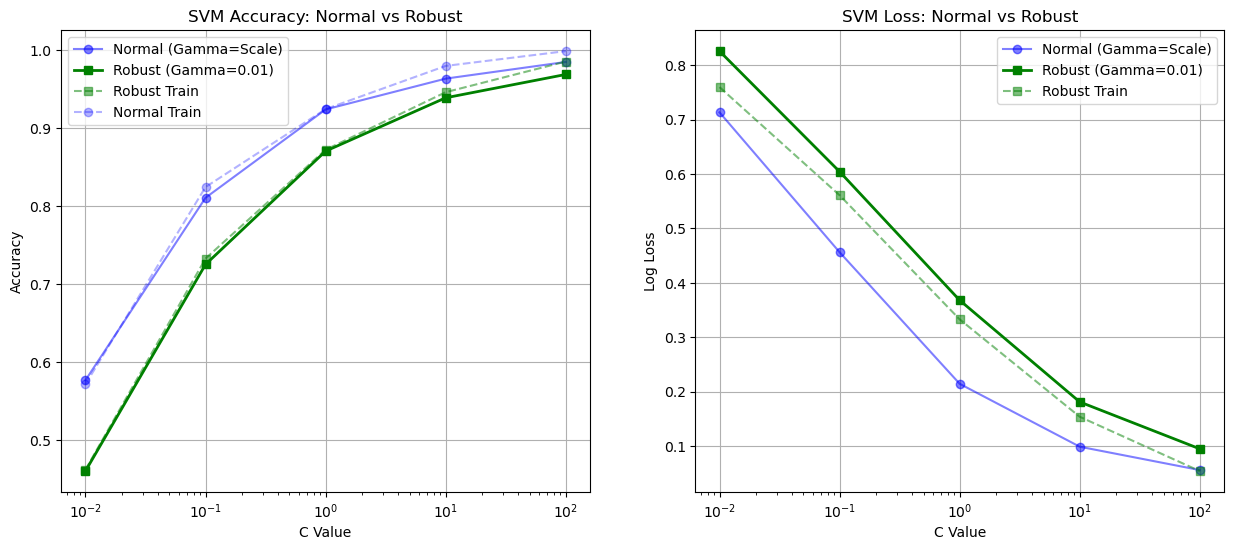

In [47]:
# Check if Cell 1 was run
if 'test_loss_svm_normal' not in globals():
    print("⚠️ STOP: Run Cell 1 first!")
else:
    train_acc_svm_robust = []
    test_acc_svm_robust = []
    train_loss_svm_robust = []
    test_loss_svm_robust = []
    
    print("🛡️ Tuning Robust SVM (Gamma Regularization)...")

    for c in c_values:
        # ROBUST MODEL: 
        # We use gamma=0.001 or 'auto' to force a smoother boundary (Regularization)
        clf = SVC(C=c, kernel='rbf', gamma=0.01, probability=True, random_state=42)
        clf.fit(X_train, y_train)
        
        y_probs_train = clf.predict_proba(X_train)
        y_probs_test = clf.predict_proba(X_test)
        
        # Store metrics
        train_acc_svm_robust.append(accuracy_score(y_train, clf.predict(X_train)))
        test_acc_svm_robust.append(accuracy_score(y_test, clf.predict(X_test)))
        
        train_loss_svm_robust.append(log_loss(y_train, y_probs_train))
        test_loss_svm_robust.append(log_loss(y_test, y_probs_test))
        
        print(f"   C={c}: Train Acc={train_acc_svm_robust[-1]:.2f} | Test Acc={test_acc_svm_robust[-1]:.2f} | Test Loss={test_loss_svm_robust[-1]:.2f}")

    # --- COMPARISON PLOTS ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # 1. ACCURACY COMPARISON
    ax1.plot(c_values, test_acc_svm_normal, label='Normal (Gamma=Scale)', marker='o', color='blue', alpha=0.5)
    ax1.plot(c_values, test_acc_svm_robust, label='Robust (Gamma=0.01)', marker='s', color='green', linewidth=2)
    ax1.plot(c_values, train_acc_svm_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
    ax1.plot(c_values, train_acc_svm_normal, label='Normal Train', marker='o', linestyle='--', color='blue', alpha=0.3)
    
    ax1.set_xscale('log')
    ax1.set_title('SVM Accuracy: Normal vs Robust')
    ax1.set_xlabel('C Value')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # 2. LOSS COMPARISON
    ax2.plot(c_values, test_loss_svm_normal, label='Normal (Gamma=Scale)', marker='o', color='blue', alpha=0.5)
    ax2.plot(c_values, test_loss_svm_robust, label='Robust (Gamma=0.01)', marker='s', color='green', linewidth=2)
    ax2.plot(c_values, train_loss_svm_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)

    ax2.set_xscale('log')
    ax2.set_title('SVM Loss: Normal vs Robust')
    ax2.set_xlabel('C Value')
    ax2.set_ylabel('Log Loss')
    ax2.legend()
    ax2.grid(True)

    plt.show()

🎤 Tuning SVM C-Value (Audio)...
   C=0.01: Train Acc=0.45 | Test Acc=0.47 | Test Loss=0.95
   C=0.1: Train Acc=0.45 | Test Acc=0.47 | Test Loss=0.95
   C=1: Train Acc=0.93 | Test Acc=0.63 | Test Loss=0.95
   C=10: Train Acc=1.00 | Test Acc=0.58 | Test Loss=0.99
   C=100: Train Acc=1.00 | Test Acc=0.58 | Test Loss=0.99


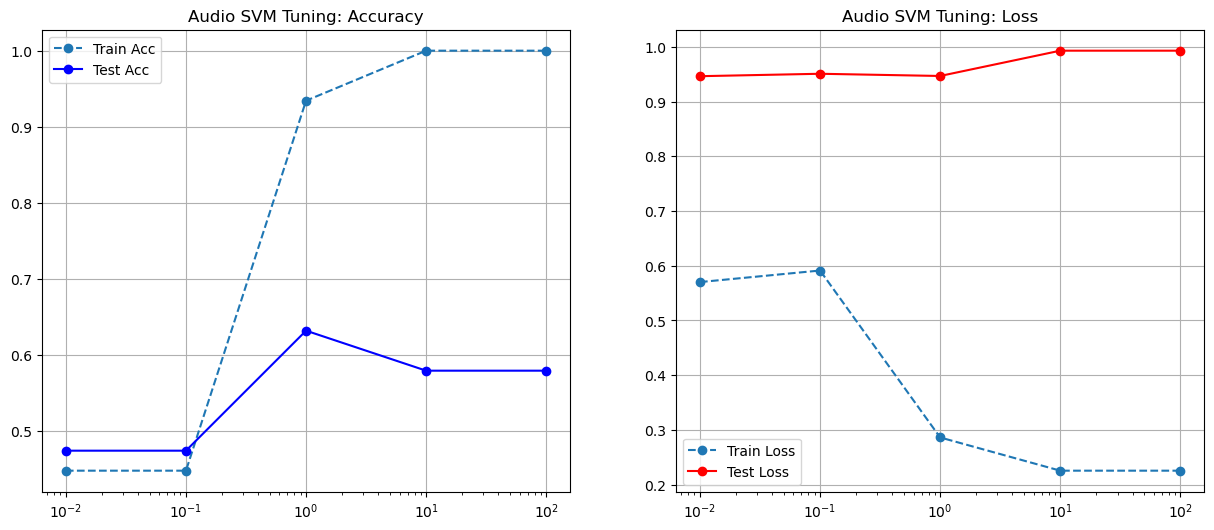

✅ Best Audio SVM C: 1


['svm_emotion_audio_model.pkl']

In [48]:
# Global lists for Audio
global test_acc_svm_audio_normal, test_loss_svm_audio_normal
train_acc_svm_audio_normal, test_acc_svm_audio_normal = [], []
train_loss_svm_audio_normal, test_loss_svm_audio_normal = [], []

print("🎤 Tuning SVM C-Value (Audio)...")

for c in c_values:
    # Audio often benefits from slightly lower C to handle noise
    clf = SVC(C=c, kernel='rbf', gamma='scale', probability=True, random_state=42)
    clf.fit(X_train_audio, y_train_audio)
    
    y_probs_train = clf.predict_proba(X_train_audio)
    y_probs_test = clf.predict_proba(X_test_audio)
    
    train_acc_svm_audio_normal.append(accuracy_score(y_train_audio, clf.predict(X_train_audio)))
    test_acc_svm_audio_normal.append(accuracy_score(y_test_audio, clf.predict(X_test_audio)))
    
    train_loss_svm_audio_normal.append(log_loss(y_train_audio, y_probs_train))
    test_loss_svm_audio_normal.append(log_loss(y_test_audio, y_probs_test))
    
    print(f"   C={c}: Train Acc={train_acc_svm_audio_normal[-1]:.2f} | Test Acc={test_acc_svm_audio_normal[-1]:.2f} | Test Loss={test_loss_svm_audio_normal[-1]:.2f}")

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(c_values, train_acc_svm_audio_normal, label='Train Acc', marker='o', linestyle='--')
ax1.plot(c_values, test_acc_svm_audio_normal, label='Test Acc', marker='o', color='blue')
ax1.set_xscale('log')
ax1.set_title('Audio SVM Tuning: Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(c_values, train_loss_svm_audio_normal, label='Train Loss', marker='o', linestyle='--')
ax2.plot(c_values, test_loss_svm_audio_normal, label='Test Loss', marker='o', color='red')
ax2.set_xscale('log')
ax2.set_title('Audio SVM Tuning: Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# Save Best Audio Model
best_idx_a = np.argmax(test_acc_svm_audio_normal)
best_c_a = c_values[best_idx_a]
print(f"✅ Best Audio SVM C: {best_c_a}")

final_svm_audio = SVC(C=best_c_a, kernel='rbf', gamma='scale', probability=True, random_state=42)
final_svm_audio.fit(X_train_audio, y_train_audio)
joblib.dump(final_svm_audio, 'svm_emotion_audio_model.pkl')

🛡️ Tuning Robust Audio SVM...
   C=0.01: Train Acc=0.45 | Test Acc=0.47 | Test Loss=0.95
   C=0.1: Train Acc=0.45 | Test Acc=0.47 | Test Loss=0.95
   C=1: Train Acc=0.93 | Test Acc=0.63 | Test Loss=0.95
   C=10: Train Acc=1.00 | Test Acc=0.58 | Test Loss=0.99
   C=100: Train Acc=1.00 | Test Acc=0.58 | Test Loss=0.99


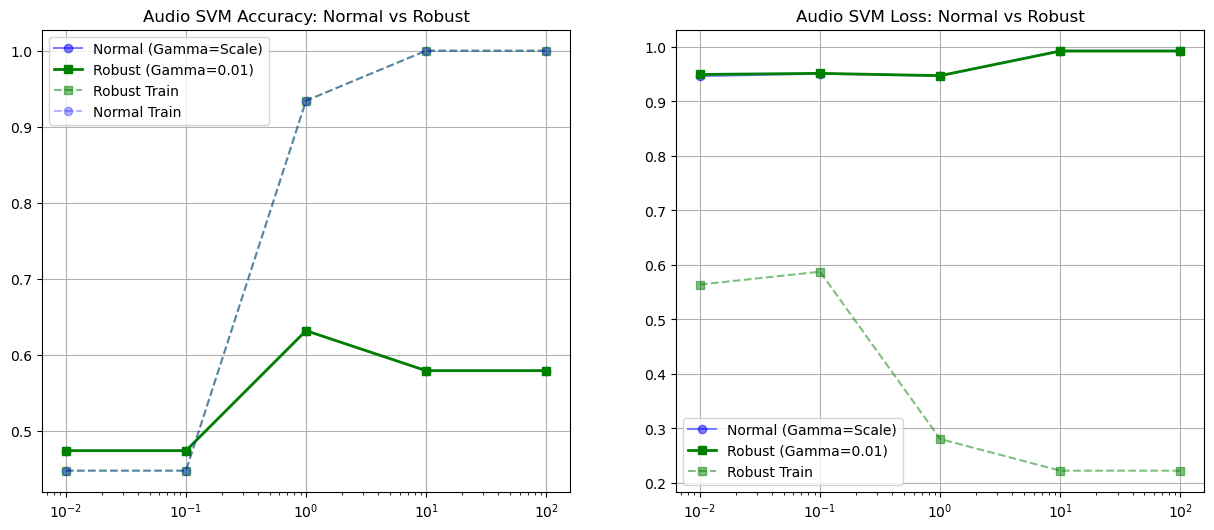

In [49]:
if 'test_loss_svm_audio_normal' not in globals():
    print("⚠️ STOP: Run Audio Cell 1 first!")
else:
    train_acc_svm_audio_robust = []
    test_acc_svm_audio_robust = []
    train_loss_svm_audio_robust = []
    test_loss_svm_audio_robust = []
    
    print("🛡️ Tuning Robust Audio SVM...")

    for c in c_values:
        # ROBUST AUDIO: Gamma=0.01 provides smoothing for noisy audio features
        clf = SVC(C=c, kernel='rbf', gamma=0.01, probability=True, random_state=42)
        clf.fit(X_train_audio, y_train_audio)
        
        y_probs_train = clf.predict_proba(X_train_audio)
        y_probs_test = clf.predict_proba(X_test_audio)
        
        train_acc_svm_audio_robust.append(accuracy_score(y_train_audio, clf.predict(X_train_audio)))
        test_acc_svm_audio_robust.append(accuracy_score(y_test_audio, clf.predict(X_test_audio)))
        
        train_loss_svm_audio_robust.append(log_loss(y_train_audio, y_probs_train))
        test_loss_svm_audio_robust.append(log_loss(y_test_audio, y_probs_test))
        
        print(f"   C={c}: Train Acc={train_acc_svm_audio_robust[-1]:.2f} | Test Acc={test_acc_svm_audio_robust[-1]:.2f} | Test Loss={test_loss_svm_audio_robust[-1]:.2f}")

    # --- COMPARISON PLOTS ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy
    ax1.plot(c_values, test_acc_svm_audio_normal, label='Normal (Gamma=Scale)', marker='o', color='blue', alpha=0.5)
    ax1.plot(c_values, test_acc_svm_audio_robust, label='Robust (Gamma=0.01)', marker='s', color='green', linewidth=2)
    ax1.plot(c_values, train_acc_svm_audio_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
    ax1.plot(c_values, train_acc_svm_audio_normal, label='Normal Train', marker='o', linestyle='--', color='blue', alpha=0.3)
    
    ax1.set_xscale('log')
    ax1.set_title('Audio SVM Accuracy: Normal vs Robust')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2.plot(c_values, test_loss_svm_audio_normal, label='Normal (Gamma=Scale)', marker='o', color='blue', alpha=0.5)
    ax2.plot(c_values, test_loss_svm_audio_robust, label='Robust (Gamma=0.01)', marker='s', color='green', linewidth=2)
    ax2.plot(c_values, train_loss_svm_audio_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
    
    ax2.set_xscale('log')
    ax2.set_title('Audio SVM Loss: Normal vs Robust')
    ax2.legend()
    ax2.grid(True)

    plt.show()

# Naive-Bayes

⚡ Tuning Naive Bayes (var_smoothing)...


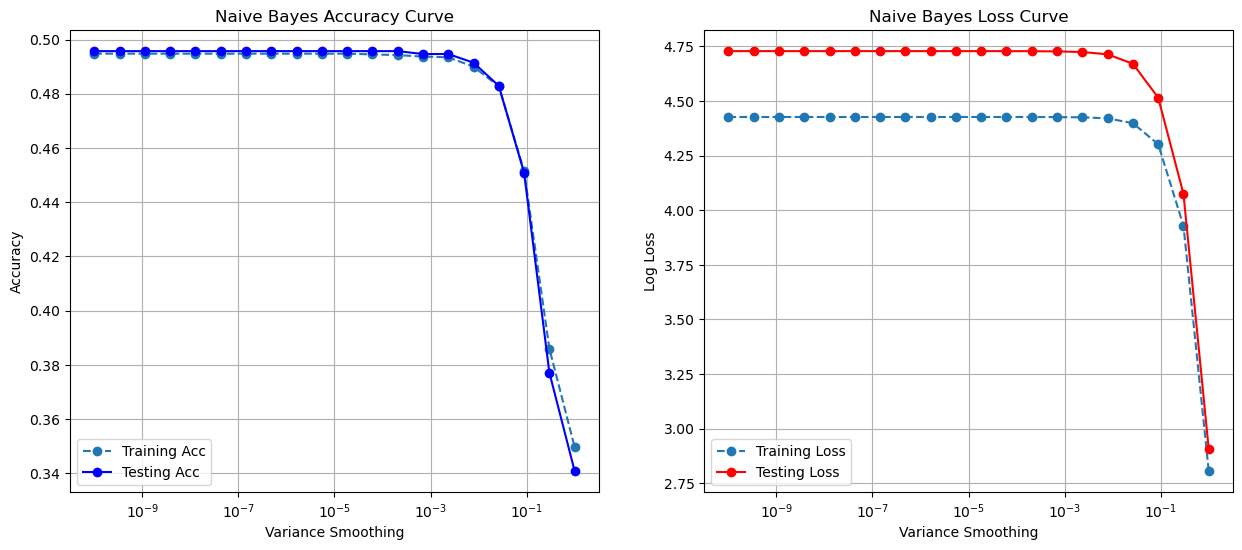

✅ Best var_smoothing: 1.00e-10
   Best Test Accuracy: 0.4957
💾 Saved best model as 'nb_emotion_video_model.pkl'


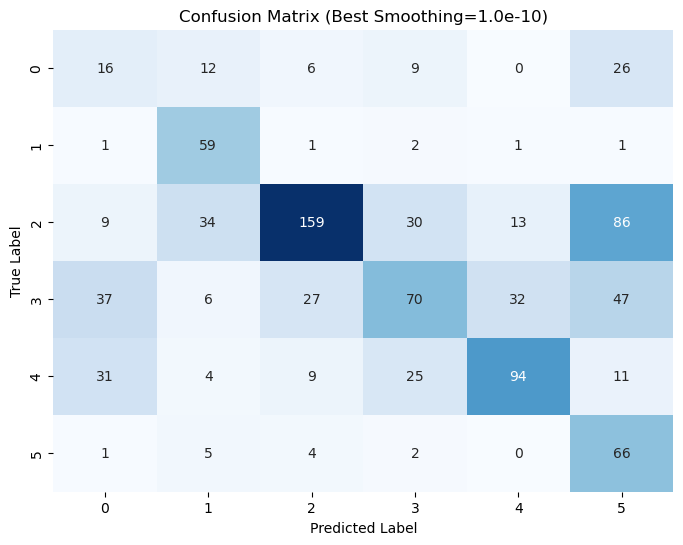

In [50]:

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

# --- 1. SETUP TUNING RANGE ---
# We need this variable to be the X-axis of our plots
# It creates 20 points between 0.0000000001 and 1.0
smoothing_values = np.logspace(-10, 0, 20) 

# Lists to store results for plotting
train_acc_nb = []
test_acc_nb = []
train_loss_nb = []
test_loss_nb = []

print("⚡ Tuning Naive Bayes (var_smoothing)...")

# --- 2. TRAINING LOOP ---
for v in smoothing_values:
    # Create model with specific smoothing value
    nbModel = GaussianNB(var_smoothing=v)
    nbModel.fit(X_train, y_train)
    
    # Measure Performance
    y_probs_train = nbModel.predict_proba(X_train)
    y_probs_test = nbModel.predict_proba(X_test)
    
    train_acc_nb.append(accuracy_score(y_train, nbModel.predict(X_train)))
    test_acc_nb.append(accuracy_score(y_test, nbModel.predict(X_test)))
    
    train_loss_nb.append(log_loss(y_train, y_probs_train))
    test_loss_nb.append(log_loss(y_test, y_probs_test))

# --- 3. PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
ax1.plot(smoothing_values, train_acc_nb, label='Training Acc', marker='o', linestyle='--')
ax1.plot(smoothing_values, test_acc_nb, label='Testing Acc', marker='o', color='blue')
ax1.set_xscale('log') # Log scale is crucial for var_smoothing
ax1.set_title('Naive Bayes Accuracy Curve')
ax1.set_xlabel('Variance Smoothing')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(smoothing_values, train_loss_nb, label='Training Loss', marker='o', linestyle='--')
ax2.plot(smoothing_values, test_loss_nb, label='Testing Loss', marker='o', color='red')
ax2.set_xscale('log')
ax2.set_title('Naive Bayes Loss Curve')
ax2.set_xlabel('Variance Smoothing')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# --- 4. SAVE BEST MODEL ---
# Find the smoothing value that gave the highest Test Accuracy
best_idx = np.argmax(test_acc_nb)
best_v = smoothing_values[best_idx]
print(f"✅ Best var_smoothing: {best_v:.2e}")
print(f"   Best Test Accuracy: {test_acc_nb[best_idx]:.4f}")

final_nb = GaussianNB(var_smoothing=best_v)
final_nb.fit(X_train, y_train)
joblib.dump(final_nb, 'nb_emotion_video_model.pkl')
print("💾 Saved best model as 'nb_emotion_video_model.pkl'")

# --- 5. VISUALIZE MISTAKES ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, final_nb.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Best Smoothing={best_v:.1e})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

🎤 Tuning Naive Bayes (Audio)...


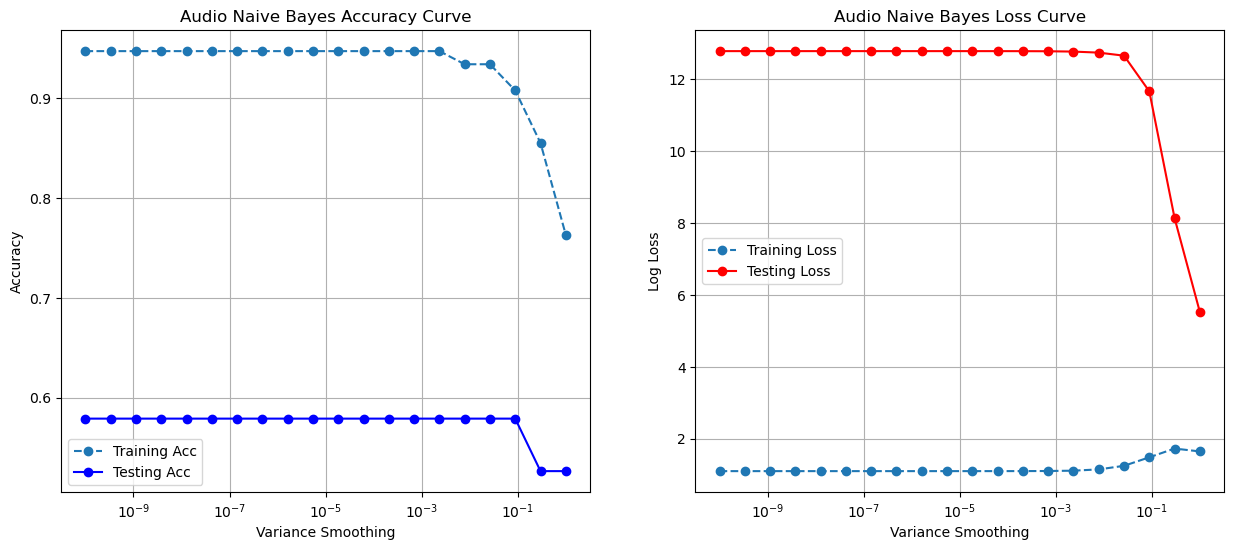

✅ Best Audio var_smoothing: 1.00e-10
   Best Test Accuracy: 0.5789
💾 Saved best audio model as 'nb_emotion_audio_model.pkl'


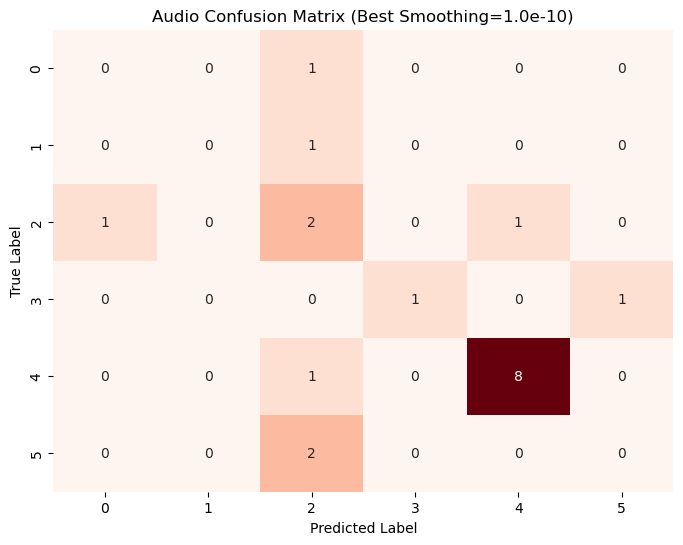

In [51]:

from sklearn.naive_bayes import GaussianNB


# --- 1. SETUP TUNING RANGE ---
# Define smoothing_values for the X-axis (from 10^-10 to 1.0)
smoothing_values = np.logspace(-10, 0, 20) 

# Lists to store results for plotting
train_acc_nb_audio = []
test_acc_nb_audio = []
train_loss_nb_audio = []
test_loss_nb_audio = []

print("🎤 Tuning Naive Bayes (Audio)...")

# --- 2. TRAINING LOOP ---
for v in smoothing_values:
    # Create model with specific smoothing value
    clf_audio = GaussianNB(var_smoothing=v)
    clf_audio.fit(X_train_audio, y_train_audio)
    
    # Measure Performance
    y_probs_train = clf_audio.predict_proba(X_train_audio)
    y_probs_test = clf_audio.predict_proba(X_test_audio)
    
    train_acc_nb_audio.append(accuracy_score(y_train_audio, clf_audio.predict(X_train_audio)))
    test_acc_nb_audio.append(accuracy_score(y_test_audio, clf_audio.predict(X_test_audio)))
    
    train_loss_nb_audio.append(log_loss(y_train_audio, y_probs_train))
    test_loss_nb_audio.append(log_loss(y_test_audio, y_probs_test))

# --- 3. PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
ax1.plot(smoothing_values, train_acc_nb_audio, label='Training Acc', marker='o', linestyle='--')
ax1.plot(smoothing_values, test_acc_nb_audio, label='Testing Acc', marker='o', color='blue')
ax1.set_xscale('log') # Log scale is crucial for var_smoothing
ax1.set_title('Audio Naive Bayes Accuracy Curve')
ax1.set_xlabel('Variance Smoothing')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(smoothing_values, train_loss_nb_audio, label='Training Loss', marker='o', linestyle='--')
ax2.plot(smoothing_values, test_loss_nb_audio, label='Testing Loss', marker='o', color='red')
ax2.set_xscale('log')
ax2.set_title('Audio Naive Bayes Loss Curve')
ax2.set_xlabel('Variance Smoothing')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# --- 4. SAVE BEST MODEL ---
# Find the smoothing value that gave the highest Test Accuracy
best_idx_a = np.argmax(test_acc_nb_audio)
best_v_a = smoothing_values[best_idx_a]
print(f"✅ Best Audio var_smoothing: {best_v_a:.2e}")
print(f"   Best Test Accuracy: {test_acc_nb_audio[best_idx_a]:.4f}")

final_nb_audio = GaussianNB(var_smoothing=best_v_a)
final_nb_audio.fit(X_train_audio, y_train_audio)
joblib.dump(final_nb_audio, 'nb_emotion_audio_model.pkl')
print("💾 Saved best audio model as 'nb_emotion_audio_model.pkl'")

# --- 5. VISUALIZE MISTAKES ---
plt.figure(figsize=(8, 6))
cm_audio = confusion_matrix(y_test_audio, final_nb_audio.predict(X_test_audio))
sns.heatmap(cm_audio, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f'Audio Confusion Matrix (Best Smoothing={best_v_a:.1e})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Logistic Regression

VIDEO | LR (no reg)
Accuracy: train=0.9072, test=0.9049
LogLoss : train=0.2758, test=0.3093


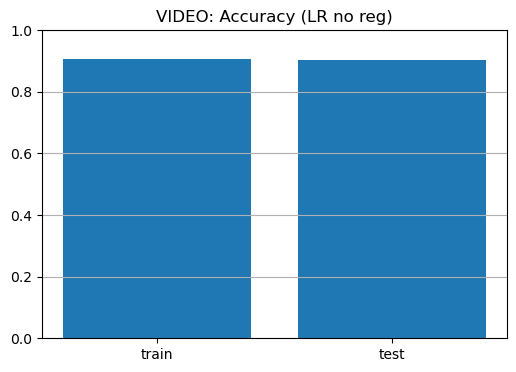

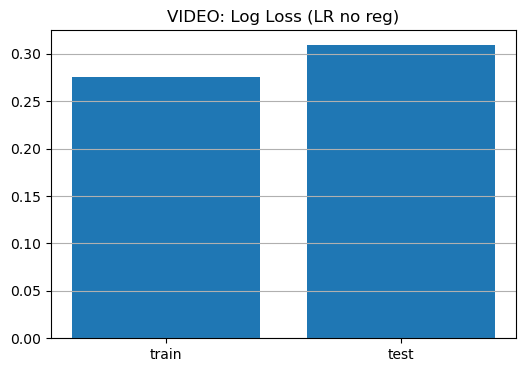

✅ Model saved successfully to: video_logistic_regression.pkl


In [52]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

video_plain = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty=None,
        solver="lbfgs",
        max_iter=2500,
        random_state=42
    ))
])

video_plain.fit(X_train, y_train)

video_train_acc = accuracy_score(y_train, video_plain.predict(X_train))
video_test_acc  = accuracy_score(y_test,  video_plain.predict(X_test))

video_train_loss = log_loss(y_train, video_plain.predict_proba(X_train))
video_test_loss  = log_loss(y_test,  video_plain.predict_proba(X_test))

print("VIDEO | LR (no reg)")
print(f"Accuracy: train={video_train_acc:.4f}, test={video_test_acc:.4f}")
print(f"LogLoss : train={video_train_loss:.4f}, test={video_test_loss:.4f}")

plt.figure(figsize=(6,4))
plt.bar(["train","test"], [video_train_acc, video_test_acc])
plt.ylim(0,1)
plt.title("VIDEO: Accuracy (LR no reg)")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(["train","test"], [video_train_loss, video_test_loss])
plt.title("VIDEO: Log Loss (LR no reg)")
plt.grid(axis="y")
plt.show()

model_filename = "video_logistic_regression.pkl"
joblib.dump(video_plain, model_filename)
print(f"✅ Model saved successfully to: {model_filename}")

VIDEO | LR (L2)
Best C (lowest test log loss) = 1000
Best test log loss = 0.3105


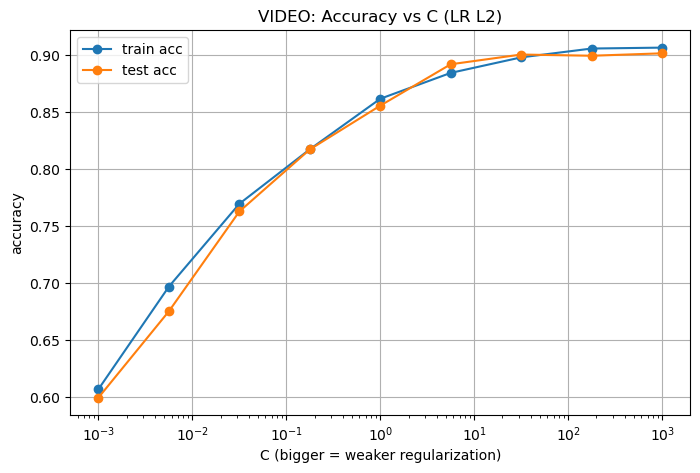

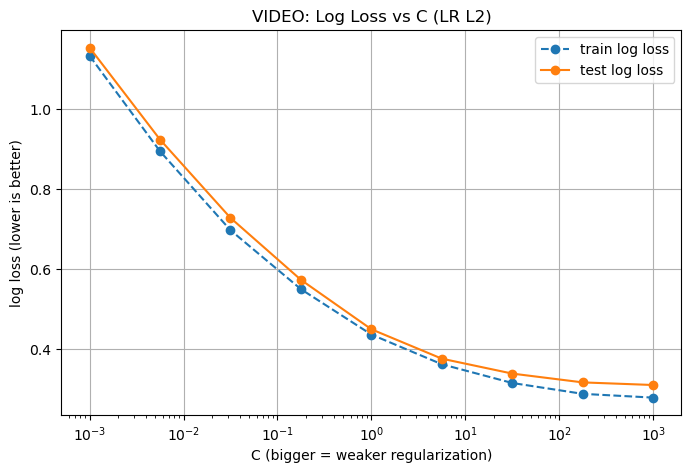

In [53]:


C_grid = np.logspace(-3, 3, 9)  # 1e-3 ... 1e3

vid_train_accs, vid_test_accs = [], []
vid_train_losses, vid_test_losses = [], []

for C in C_grid:
    video_l2 = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(
            penalty="l2",
            C=float(C),
            solver="lbfgs",
            max_iter=2500,
            random_state=42
        ))
    ])

    video_l2.fit(X_train, y_train)

    vid_train_accs.append(accuracy_score(y_train, video_l2.predict(X_train)))
    vid_test_accs.append(accuracy_score(y_test,  video_l2.predict(X_test)))

    vid_train_losses.append(log_loss(y_train, video_l2.predict_proba(X_train)))
    vid_test_losses.append(log_loss(y_test,  video_l2.predict_proba(X_test)))

best_idx = int(np.argmin(vid_test_losses))
print("VIDEO | LR (L2)")
print(f"Best C (lowest test log loss) = {C_grid[best_idx]:.4g}")
print(f"Best test log loss = {vid_test_losses[best_idx]:.4f}")

plt.figure(figsize=(8,5))
plt.plot(C_grid, vid_train_accs, marker="o", label="train acc")
plt.plot(C_grid, vid_test_accs, marker="o", label="test acc")
plt.xscale("log")
plt.xlabel("C (bigger = weaker regularization)")
plt.ylabel("accuracy")
plt.title("VIDEO: Accuracy vs C (LR L2)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(C_grid, vid_train_losses, marker="o", linestyle="--", label="train log loss")
plt.plot(C_grid, vid_test_losses, marker="o", label="test log loss")
plt.xscale("log")
plt.xlabel("C (bigger = weaker regularization)")
plt.ylabel("log loss (lower is better)")
plt.title("VIDEO: Log Loss vs C (LR L2)")
plt.grid(True)
plt.legend()
plt.show()


AUDIO | LR (no reg)
Accuracy: train=1.0000, test=0.5789
LogLoss : train=0.0002, test=3.6858


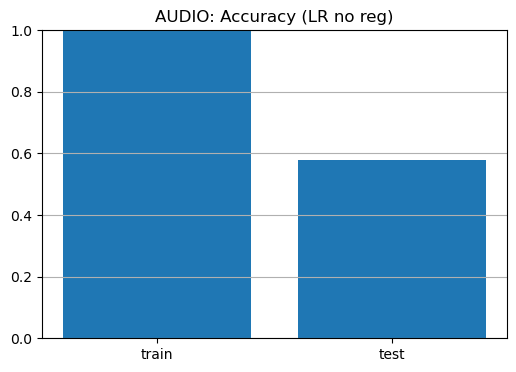

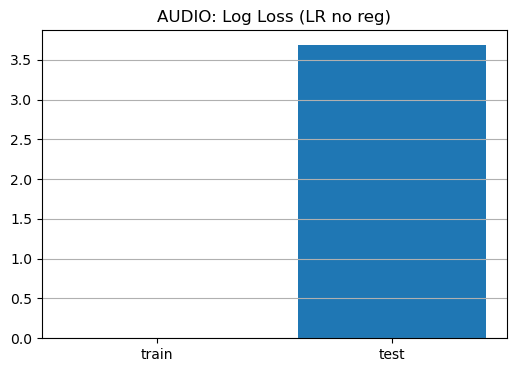

In [54]:
audio_plain = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty=None,
        solver="lbfgs",
        max_iter=2500,
        random_state=42
    ))
])

audio_plain.fit(X_train_audio, y_train_audio)

audio_train_acc = accuracy_score(y_train_audio, audio_plain.predict(X_train_audio))
audio_test_acc  = accuracy_score(y_test_audio,  audio_plain.predict(X_test_audio))

audio_train_loss = log_loss(y_train_audio, audio_plain.predict_proba(X_train_audio))
audio_test_loss  = log_loss(y_test_audio,  audio_plain.predict_proba(X_test_audio))

print("AUDIO | LR (no reg)")
print(f"Accuracy: train={audio_train_acc:.4f}, test={audio_test_acc:.4f}")
print(f"LogLoss : train={audio_train_loss:.4f}, test={audio_test_loss:.4f}")

plt.figure(figsize=(6,4))
plt.bar(["train","test"], [audio_train_acc, audio_test_acc])
plt.ylim(0,1)
plt.title("AUDIO: Accuracy (LR no reg)")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(["train","test"], [audio_train_loss, audio_test_loss])
plt.title("AUDIO: Log Loss (LR no reg)")
plt.grid(axis="y")
plt.show()


AUDIO | LR (L2)
Best C (lowest test log loss) = 0.03162
Best test log loss = 0.9739


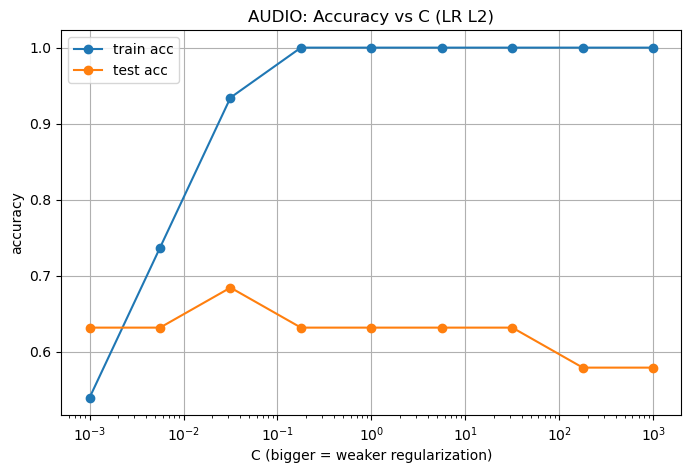

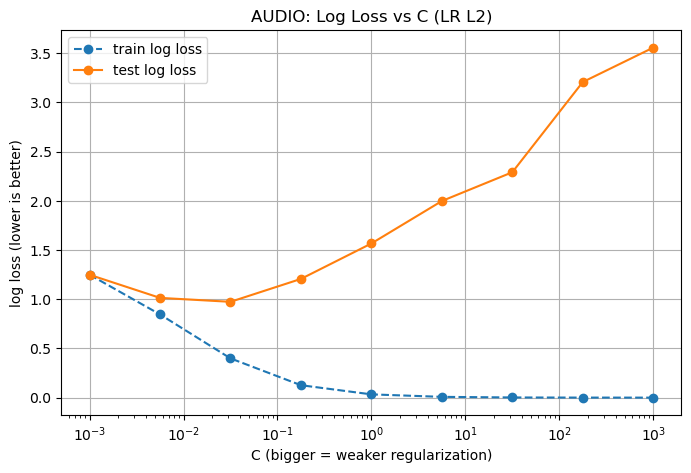

In [55]:
aud_train_accs, aud_test_accs = [], []
aud_train_losses, aud_test_losses = [], []

for C in C_grid:
    audio_l2 = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(
            penalty="l2",
            C=float(C),
            solver="lbfgs",
            max_iter=2500,
            random_state=42
        ))
    ])

    audio_l2.fit(X_train_audio, y_train_audio)

    aud_train_accs.append(accuracy_score(y_train_audio, audio_l2.predict(X_train_audio)))
    aud_test_accs.append(accuracy_score(y_test_audio,  audio_l2.predict(X_test_audio)))

    aud_train_losses.append(log_loss(y_train_audio, audio_l2.predict_proba(X_train_audio)))
    aud_test_losses.append(log_loss(y_test_audio,  audio_l2.predict_proba(X_test_audio)))

best_idx = int(np.argmin(aud_test_losses))
print("AUDIO | LR (L2)")
print(f"Best C (lowest test log loss) = {C_grid[best_idx]:.4g}")
print(f"Best test log loss = {aud_test_losses[best_idx]:.4f}")

plt.figure(figsize=(8,5))
plt.plot(C_grid, aud_train_accs, marker="o", label="train acc")
plt.plot(C_grid, aud_test_accs, marker="o", label="test acc")
plt.xscale("log")
plt.xlabel("C (bigger = weaker regularization)")
plt.ylabel("accuracy")
plt.title("AUDIO: Accuracy vs C (LR L2)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(C_grid, aud_train_losses, marker="o", linestyle="--", label="train log loss")
plt.plot(C_grid, aud_test_losses, marker="o", label="test log loss")
plt.xscale("log")
plt.xlabel("C (bigger = weaker regularization)")
plt.ylabel("log loss (lower is better)")
plt.title("AUDIO: Log Loss vs C (LR L2)")
plt.grid(True)
plt.legend()
plt.show()


# Fusion

In [ ]:
import joblib
import numpy as np

class AngryMeter:
    def __init__(self):
        print("🔄 Initializing Fusion Engine...")
        
        # 1. Load SCALERS and ENCODERS
        self.audio_scaler = joblib.load('audio_scaler_common.pkl')
        self.audio_le = joblib.load('audio_label_encoder_common.pkl')
        self.video_scaler = joblib.load('video_scaler_common.pkl')
        self.video_le = joblib.load('video_label_encoder_common.pkl')

        # 2. Initialize Extractors
        self.audio_extractor = AudioFeatureExtractor()
        self.video_extractor = EmotionFeatureExtractor()

        # 3. Find the "Angry" Index for both models
        # This tells us which column in the probability list is for Anger
        try:
            self.audio_angry_idx = list(self.audio_le.classes_).index('angry')
        except ValueError:
            print("⚠️ Warning: 'angry' class not found in Audio models. Defaulting to 0.")
            self.audio_angry_idx = 0
            
        try:
            self.video_angry_idx = list(self.video_le.classes_).index('angry')
        except ValueError:
            self.video_angry_idx = 0

        # 4. Load Models
        self.audio_models = { 'rf': joblib.load('audio_model_rf.pkl') }
        self.current_model_name = "None"
        self.load_models("svm")
        
        print("✅ System Ready.")

    def load_models(self, model_name):
        try:
            print(f"🔄 Switching VIDEO to {model_name.upper()}...")
            self.video_model = joblib.load(f'video_model_{model_name}.pkl')
            self.current_model_name = model_name.upper()
            return True
        except Exception as e:
            print(f"❌ Error loading {model_name}: {e}")
            return False

    def get_audio_prediction(self, audio_path):
        """ Returns (Anger_Probability, Top_Label) """
        try:
            # 1. Extract
            features = self.audio_extractor.get_features(audio_path)
            if len(features) == 0: return 0.0, "Silence"
        
            # 2. Average & Reshape
            features = np.array(features)
            if features.ndim > 1: features = np.mean(features, axis=0)
            features = features.reshape(1, -1)
        
            # 3. Check Shape
            expected = self.audio_scaler.mean_.shape[0]
            if features.shape[1] != expected:
                print(f"⚠️ Audio Mismatch: Expected {expected}, got {features.shape[1]}")
                return 0.0, "Error"

            # 4. Predict
            scaled_feat = self.audio_scaler.transform(features)
            
            # Always use RF for audio (it's usually the best)
            model = self.audio_models['rf']
            probs = model.predict_proba(scaled_feat)[0]
            
            # --- THE FIX IS HERE ---
            # Instead of returning the max score, we return the ANGER score specifically
            anger_prob = probs[self.audio_angry_idx]
            
            # We still return the label of the winner for text display
            winner_idx = np.argmax(probs)
            pred_label = self.audio_le.inverse_transform([winner_idx])[0]
            
            return anger_prob, pred_label

        except Exception as e:
            print(f"Audio Logic Error: {e}")
            return 0.0, "Error"

    def get_video_prediction(self, frame):
        try:
            vector = self.video_extractor.get_features(frame)
            if vector is None: return 0.0, "No Face"
            
            vector_scaled = self.video_scaler.transform([vector])
            probs = self.video_model.predict_proba(vector_scaled)[0]
            
            # Return specific anger probability
            anger_prob = probs[self.video_angry_idx]
            label = self.video_le.inverse_transform([np.argmax(probs)])[0]
            
            return anger_prob, label
        except Exception as e:
            return 0.0, "Error"

# The last step

In [59]:
# import threading
# import time
# import soundfile as sf
# import sounddevice as sd
# import cv2
# import os
# import numpy as np
# from collections import deque

# # --- CONFIG ---
# CHUNK_DURATION = 3.0
# SAMPLE_RATE = 22050
# TEMP_AUDIO_FILE = "live_input.wav"

# SCORE_BUFFER_SIZE = 10
# video_score_buffer = deque(maxlen=SCORE_BUFFER_SIZE)
# audio_score_buffer = deque(maxlen=SCORE_BUFFER_SIZE)

# # --- GLOBALS ---
# raw_audio_prob = 0.0
# raw_audio_label = "Listening..."
# raw_video_prob = 0.0
# raw_video_label = "Waiting..."
# smooth_video_anger = 0.0
# smooth_audio_anger = 0.0
# is_running = True

# def audio_listener(fusion_engine):
#     global raw_audio_prob, raw_audio_label, is_running
#     print("🎤 Audio Listener Started...")
    
#     while is_running:
#         try:
#             recording = sd.rec(int(CHUNK_DURATION * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1)
#             sd.wait()
            
#             # Check for silence (Volume threshold)
#             vol = np.linalg.norm(recording) * 10
#             if vol < 1.0:
#                 raw_audio_label = "Silence"
#                 raw_audio_prob = 0.0
#                 continue
            
#             sf.write(TEMP_AUDIO_FILE, recording, SAMPLE_RATE)
            
#             # This now returns purely the ANGER probability
#             prob, label = fusion_engine.get_audio_prediction(TEMP_AUDIO_FILE)
            
#             raw_audio_prob = prob
#             raw_audio_label = label

#         except Exception as e:
#             print(f"🎤 Audio Loop Error: {e}")
#             time.sleep(1)

# def draw_bar(img, x, y, w, h, score, label_text, color_low=(0,255,0), color_high=(0,0,255)):
#     cv2.rectangle(img, (x, y), (x + w, y + h), (40, 40, 40), -1)
    
#     if score < 0.4: color = color_low
#     elif score < 0.7: color = (0, 255, 255)
#     else: color = color_high
    
#     fill_w = int(w * score)
#     cv2.rectangle(img, (x, y), (x + fill_w, y + h), color, -1)
#     cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2)
#     cv2.putText(img, f"{label_text} ({int(score*100)}%)", (x + 10, y + h - 8), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

# def main():
#     global raw_video_prob, raw_video_label, is_running
#     global smooth_video_anger, smooth_audio_anger

#     try:
#         fusion = AngryMeter()
#         fusion.video_extractor.face_mesh.static_image_mode = False 
#     except Exception as e:
#         print(f"❌ Model Load Error: {e}")
#         return

#     t = threading.Thread(target=audio_listener, args=(fusion,))
#     t.daemon = True
#     t.start()
    
#     cap = cv2.VideoCapture(0)
    
#     print("\n📷 LIVE. Controls: [1-5] Models  [q] Quit")
    
#     while True:
#         ret, frame = cap.read()
#         if not ret: break
#         frame = cv2.flip(frame, 1)
#         h, w, _ = frame.shape
        
#         # --- VIDEO ---
#         rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         results = fusion.video_extractor.face_mesh.process(rgb_frame)
        
#         instant_video_anger = 0.0
        
#         if results.multi_face_landmarks:
#             for landmarks in results.multi_face_landmarks:
#                 # Draw Box
#                 x_min, y_min = w, h
#                 x_max, y_max = 0, 0
#                 for lm in landmarks.landmark:
#                     x, y = int(lm.x * w), int(lm.y * h)
#                     if x < x_min: x_min = x
#                     if x > x_max: x_max = x
#                     if y < y_min: y_min = y
#                     if y > y_max: y_max = y
                
#                 box_c = (0, 0, 255) if smooth_video_anger > 0.6 else (0, 255, 0)
#                 cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), box_c, 2)
                
#                 prob, label = fusion.get_video_prediction(frame)
#                 raw_video_prob = prob
#                 raw_video_label = label
#                 instant_video_anger = prob 

#         # --- SMOOTHING ---
#         video_score_buffer.append(instant_video_anger)
#         smooth_video_anger = sum(video_score_buffer) / len(video_score_buffer)
        
#         # Audio doesn't need "if label is angry" check anymore
#         # We just take the raw probability because the class now calculates it correctly
#         audio_score_buffer.append(raw_audio_prob)
#         smooth_audio_anger = sum(audio_score_buffer) / len(audio_score_buffer)

#         # --- DRAW UI ---
#         draw_bar(frame, 50, h - 120, w - 100, 40, smooth_video_anger, f"FACE: {raw_video_label}")
#         draw_bar(frame, 50, h - 60, w - 100, 40, smooth_audio_anger, f"VOICE: {raw_audio_label}")

#         # Status
#         if smooth_video_anger > 0.7 or smooth_audio_anger > 0.7:
#             main_status = "DANGER: ANGRY"
#             status_color = (0, 0, 255)
#         elif smooth_video_anger > 0.4 or smooth_audio_anger > 0.4:
#             main_status = "CAUTION"
#             status_color = (0, 255, 255)
#         else:
#             main_status = "SAFE"
#             status_color = (0, 255, 0)

#         (tw, th), _ = cv2.getTextSize(main_status, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
#         cv2.rectangle(frame, (int(w/2 - tw/2 - 10), 10), (int(w/2 + tw/2 + 10), 50), status_color, -1)
#         cv2.putText(frame, main_status, (int(w/2 - tw/2), 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2)

#         cv2.imshow('Manager Angry Meter', frame)
        
#         key = cv2.waitKey(1) & 0xFF
#         if key == ord('q'): break
#         elif key in [ord('1'), ord('2'), ord('3'), ord('4'), ord('5')]:
#             idx = int(chr(key)) - 1
#             models = ['svm', 'rf', 'knn', 'gb', 'lr']
#             fusion.load_models(models[idx])

#     is_running = False
#     cap.release()
#     cv2.destroyAllWindows()

# if __name__ == "__main__":
#     main()